<div style="background: #6b7b8c; color: white; padding: 10px; font-size: 18pt; line-height: 1.5">
<b><center> Анализ рекламных источников мобильной игры<b>
<b><center> "Космические братья"<b>
    
</div>

## Оглавление

[Описание задачи](#description)  
[Импорты и настройки](#imports)

[1 Изучение общей информации](#start) 
* [1.1 Открытие файла с данными, первый взгляд на данные](#open)
* [1.2 Предобработка данных](#preprocessing)
* [1.3 Добавление расчетных данных](#adding_data)   

[Вывод по пункту 1](#start_conclusion)

[2 Исследовательский анализ данных](#analysis)    
* [2.1 Обзор распределения числовых признаков и уникальных значений](#numerical_parameter)    
  * [2.1.1 Обзор признаков game_actions](#game_actions)
  * [2.1.2 Обзор признаков user_source](#user_source)
  * [2.1.3 Обзор признаков ad_costs](#ad_costs)
* [2.2 Обзор распределения признаков по группам завершивших и не завершивших уровень](#feature_distribution_churn)   
  * [2.2.1 Создание датафрейма с данными по уникальным игрокам events_by_users](#events_by_users)
  * [2.2.2 Характеристики завершаемости уровня](#is_complete)
  * [2.2.3 Анализ признаков в зависимости от завершенности уровня](#features_if_completed)

[Вывод по пункту 2](#analysis_conclusion)   


[3 Анализ влияния источника перехода в игру на поведение пользователя](#source_analysis)
* [3.1 Пользовательские пути внутри игры](#user_path)
* [3.2 Анализ источников перехода в игру](#distribution_of_players)
* [3.3 Типичное поведение игроков в зависимости от источника перехода](#clusters)
* [3.4 Продуктовые метрики (DAU, WAU), когортный анализ по времени](#cohorts)
* [3.5 Эффективность источников (маркетинговые метрики)](#romi)

[Вывод по пункту 3](#source_analysis_conclusion)

[4 Проверка статистических гипотез](#tests)
* [4.1 Различия во времени завершения уровня в зависимости от способа прохождения уровня](#tests_1)
* [4.2 Различия в способе завершения уровня в зависимости от источника перехода в игру](#tests_2)    

[Вывод по пункту 4](#tests_conclusion)


[Общий вывод и рекомендации](#total_conclusion)

[Презентация](#present)

[Dashboard Tableau](#dash)

<a id='description'></a>
## Описание задачи

Объектом исследования выступает мобильная игра "Космические братья".

**Цель** - анализ источников перехода в игру для выявления эффективности маркетинговых расходов.

Задачи:
* проанализировать поведение игроков,
* из каких источников приходят клиенты и сколько стоит источник,
* когда расходы на привлечение клиента окупаются.

Предоставлены 3 csv-файла:
* game_actions.csv - логи событий в игре по пользователям, зарегистрированных с игре с 4 по 10 мая, события ограничены первым уровнем;
* ad_costs.csv - затраты на маркетинг по источникам;
* user_source.csv - справочник соответствия игроков источнику перехода в игру.

<a id='imports'></a>
### Импорты и настройки

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option("max_colwidth", -1)

In [3]:
sns.set(style="ticks")

In [4]:
def first_look(df):
    """Display basic information about the dataframe"""
    
    display(df.info())
    display(df.head(5))
    display(df.describe())
    display('Доля пустых строк:', df.isna().mean())
    display('Количество дублирующихся строк:', df.duplicated().sum())

<a id='start'></a>
## 1 Изучение общей информации

<a id='open'></a>
### 1.1 Открытие файла с данными, первый взгляд на данные

In [5]:
game_actions = pd.read_csv('/datasets/game_actions.csv')

In [6]:
first_look(game_actions)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
event_datetime    135640 non-null object
event             135640 non-null object
building_type     127957 non-null object
user_id           135640 non-null object
project_type      1866 non-null object
dtypes: object(5)
memory usage: 5.2+ MB


None

,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN


,event_datetime,event,building_type,user_id,project_type
count,135640,135640,127957,135640,1866
unique,128790,3,3,13576,1
top,2020-05-07 03:10:43,building,spaceport,ff841992-d93b-462e-bc6e-18c24a514f36,satellite_orbital_assembly
freq,4,127957,59325,22,1866


'Доля пустых строк:'

event_datetime   0.00
event            0.00
building_type    0.06
user_id          0.00
project_type     0.99
dtype: float64

'Количество дублирующихся строк:'

1

Датасет `game_actions` содержит 135640 строк по 5 столбцам. Незаполненные строки есть в столбцах `building_type` (6%) и `project_type` (99%), но заполнению они не подлежат, так как пропуск означает отсутствие события с данным типом. Присутствует одна дублирующаяся строка, удалим её.    
`event_datetime`приведем в явном виде к типу datetime, в остальных столбцах тип соответствует хранимым значениям.    

Среди трех уникальных событий наиболее часто встречающееся событие - постройка (building), среди типов построек наиболее частое - spaceport - также из трех уникальных.    
**13576 уникальных игроков**, с максимальным количеством событий на первом уровне в количестве 22 штук.   
Среди проектов есть только один тип - satellite_orbital_assembly, было реализовано всего 1866 раз.

In [7]:
user_source = pd.read_csv('/datasets/user_source.csv')

In [8]:
first_look(user_source)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
user_id    13576 non-null object
source     13576 non-null object
dtypes: object(2)
memory usage: 212.2+ KB


None

,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads


,user_id,source
count,13576,13576
unique,13576,4
top,e63a263d-8659-473a-9e6f-4f4566f440cb,yandex_direct
freq,1,4817


'Доля пустых строк:'

user_id   0.00
source    0.00
dtype: float64

'Количество дублирующихся строк:'

0

Датасет `user_source` содержит 13576 записей, ровно столько же уникальных игроков было обнаружено в основном датасете с логами. Игроки приходят из 4 источников, наиболее популярный - яндекс директ (4817 игроков).   

Пустых строк и дубликатов нет, типы данных соответствуют содержимому.

In [9]:
ad_costs = pd.read_csv('/datasets/ad_costs.csv')

In [10]:
first_look(ad_costs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
source    28 non-null object
day       28 non-null object
cost      28 non-null float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes


None

,source,day,cost
0,facebook_ads,2020-05-03,935.88
1,facebook_ads,2020-05-04,548.35
2,facebook_ads,2020-05-05,260.19
3,facebook_ads,2020-05-06,177.98
4,facebook_ads,2020-05-07,111.77


,cost
count,28.00
mean,271.56
std,286.87
min,23.31
25%,66.75
50%,160.06
75%,349.03
max,969.14


'Доля пустых строк:'

source   0.00
day      0.00
cost     0.00
dtype: float64

'Количество дублирующихся строк:'

0

Датасет `ad_costs` содержит 28 строк по 3 стобцам (информация по стоимости каждого источника и времени осуществления затрат).   

Затраты на источники имеют довольно сильный разброс - от 23,31 у.е. до 969,14 у.е. В среднем один источник в день обходится в 271,56 у.е., а типичный источник стоит 160,06 у.е. (распределение по стоимости источников имеет положительный скос и мы будем наблюдать удлиненный хвост справа, другими словами больше половины маркетинговых затрат составляют до 200 у.е. в день, но было несколько крупных трат, которые и увеличивают среднюю стоимость источников, возможно, это затраты на первоначальном этапе, требующим бОльшие вложения для выхода на рынок).   


Пустых строк и дубликатов нет, типы данных соответствуют содержимому.

<a id='preprocessing'></a>
### 1.2 Предобработка данных

In [11]:
# удаление дубликата
game_actions = game_actions.drop_duplicates()

In [12]:
#приведение типов
game_actions['event_datetime'] = pd.to_datetime(game_actions['event_datetime'])

In [13]:
game_actions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135639 entries, 0 to 135639
Data columns (total 5 columns):
event_datetime    135639 non-null datetime64[ns]
event             135639 non-null object
building_type     127956 non-null object
user_id           135639 non-null object
project_type      1866 non-null object
dtypes: datetime64[ns](1), object(4)
memory usage: 6.2+ MB


Итак, в анализируемом датафрейме **135639** событий (на 1 событие постройки меньше по сравнению с исходным df)

<a id='adding_data'></a>
### 1.3 Добавление расчетных данных

In [14]:
# добавляем дату в формате день-месяц-год
game_actions['date'] = game_actions['event_datetime'].dt.date

In [15]:
# добавляем год и неделю для расчета wau
game_actions['year']  = game_actions['event_datetime'].dt.year
game_actions['week'] = game_actions['event_datetime'].dt.week

In [16]:
# добавляем дату первого события и лайфтайм для когортного анализа по неделям
game_actions = game_actions.merge(
    game_actions.sort_values(by=['user_id', 'date']).groupby('user_id')['date'].first(),
    on='user_id', how='left')
game_actions = game_actions.rename(columns={'date_x':'date', 'date_y':'first_date'})

game_actions['cohort_lifetime'] = ((game_actions['date'] - game_actions['first_date']) / 
                                   np.timedelta64(1, 'W')).round()

In [17]:
# создадим вспомогательный столбец для построения в дальнейшем последовательности событий
# описывает какое именно событие происходит через тип постройки, тип проекта или завершение уровня

game_actions['steps'] = (game_actions['building_type']
                         .fillna(game_actions['project_type'])
                         .fillna(game_actions['event']))

<a id='start_conclusion'></a>
## Вывод по шагу 1

Для анализа эффективности источников перехода в игру будут использованы 3 источника данных:
- данные по событиям игроков в игре,
- данные по источникам перехода в игру,
- информация по маркетинговым затратам.   

В предоставленных данных был обнаружен дубликат, который мы удалили. В остальном данные не содержат явных проблем - пропуски в основном датасете замене не подлежат.    
Столбец с датой и временем приведен в явном виде к формату datetime, а также добавлены расчетные данные для проведения дальнейшего анализа.

Полученный основной датасет после преобразований:

In [18]:
game_actions.head(3)

,event_datetime,event,building_type,user_id,project_type,date,year,week,first_date,cohort_lifetime,steps
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-04,2020,19,2020-05-04,0.00,assembly_shop
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,2020-05-04,2020,19,2020-05-04,0.00,assembly_shop
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN,2020-05-04,2020,19,2020-05-04,0.00,assembly_shop


<a id='analysis'></a>
## 2 Исследовательский анализ данных 

<a id='numerical_parameter'></a>
### 2.1 Обзор распределения числовых признаков и уникальных значений

<a id='game_actions'></a>
### 2.1.1 Обзор признаков game_actions

In [19]:
print('Логи содержат данные с {} до {}'.format(game_actions['event_datetime'].min(), game_actions['event_datetime'].max()))

Логи содержат данные с 2020-05-04 00:00:01 до 2020-06-05 12:32:49


Располагаем данными чуть больше месяца, посмотрим распределение активности игроков по дням

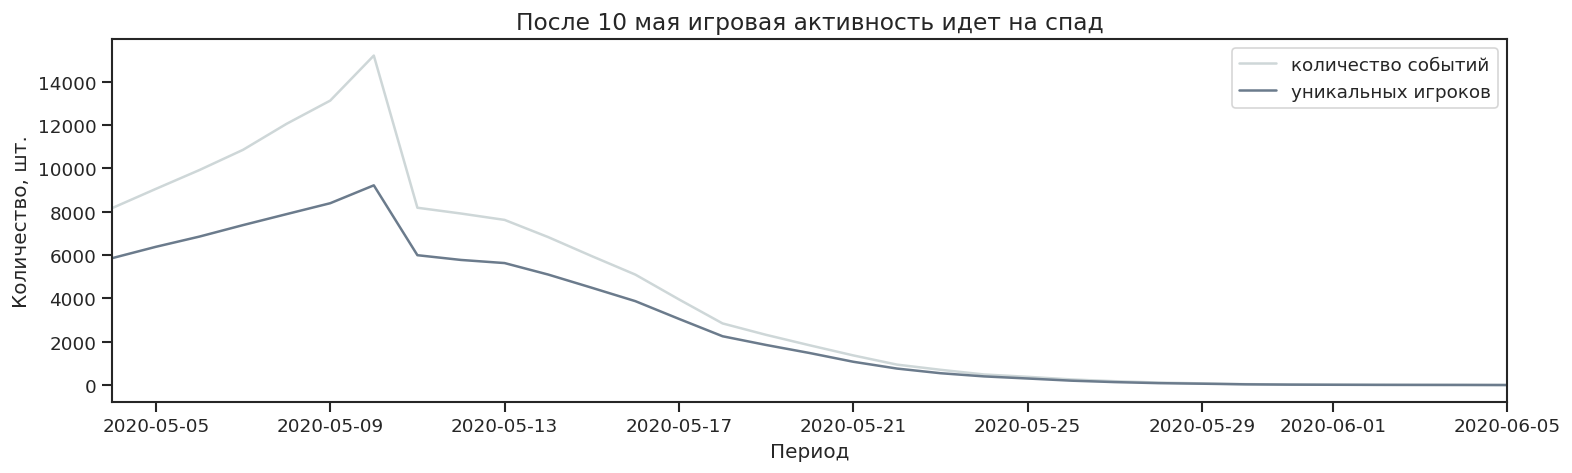

In [20]:
fig, ax=plt.subplots(figsize=(15,4), dpi=120)
game_actions.groupby('date')['user_id'].count().plot(ax=ax, color='#ced7d8', label='количество событий')
game_actions.groupby('date')['user_id'].nunique().plot(ax=ax, color='#6b7b8c', label='уникальных игроков')
plt.title('После 10 мая игровая активность идет на спад', fontsize=14)
plt.xlabel('Период')
plt.ylabel('Количество, шт.')
plt.legend()
plt.show()

В логах содержатся данные об игроках, которые начали пользоваться приложением в период с 4 по 10 мая включительно, именно в этот период мы наблюдаем максимальную активность в игре. После 10 мая количество событий как и количество уникальных игроков начинает уменьшаться день ото дня, вероятно, часть игроков проходят уровень, а часть игроков покидает игру.

In [21]:
print('Количество игроков на пике: {}'.format(game_actions.groupby('date')['user_id'].nunique().max()))

Количество игроков на пике: 9219


Посмотрим, какое количество событий в среднем приходится на одного игрока ежедневно

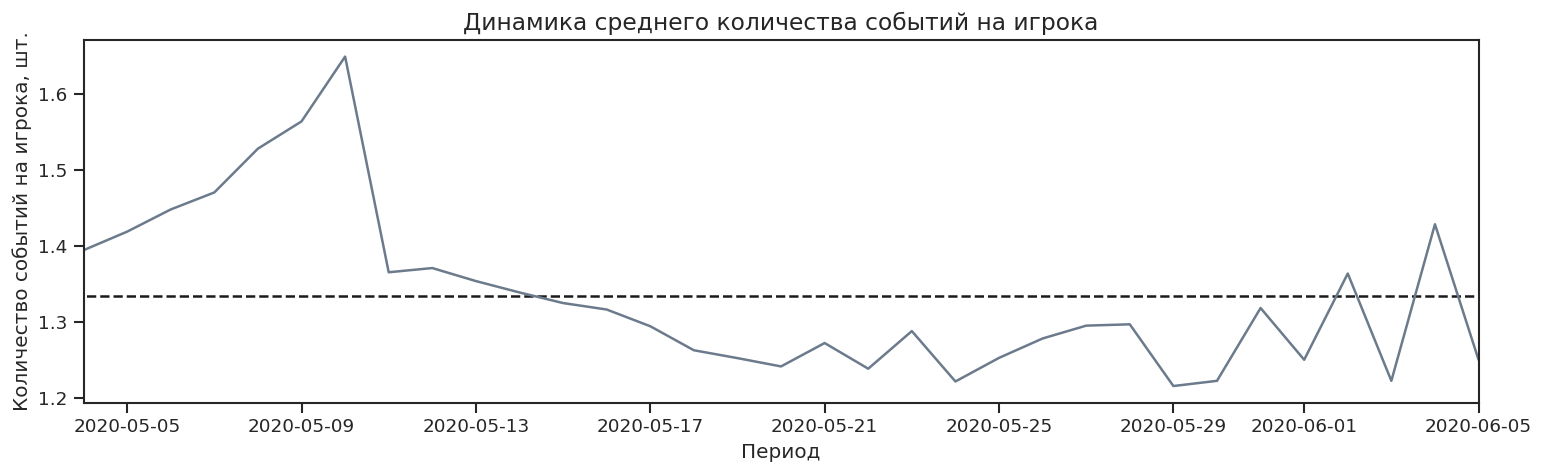

In [22]:
events_per_user = (game_actions.groupby('date')['user_id'].count() / 
                   game_actions.groupby('date')['user_id'].nunique())
fig, ax=plt.subplots(figsize=(15,4), dpi=120)
events_per_user.plot(ax=ax, color='#6b7b8c')
plt.hlines(events_per_user.mean(), 0, game_actions['date'].max(), linestyles='dashed')
plt.title('Динамика среднего количества событий на игрока', fontsize=14)
plt.xlabel('Период')
plt.ylabel('Количество событий на игрока, шт.')
plt.show()

In [23]:
print('На одного игрока в среднем приходится {:.1f} событий в день'.format(events_per_user.mean()))

На одного игрока в среднем приходится 1.3 событий в день


Пик событий приходится также на 10 мая

Посмотрим, какое количество событий приходится на одного игрока во время прохождения первого уровня игры

In [24]:
print('На одного игрока в среднем приходится {:.1f} событий'.
      format(len(game_actions['user_id']) / game_actions['user_id'].nunique()))

На одного игрока в среднем приходится 10.0 событий


Посмотрим какие из событий наиболее популярны у игроков

In [25]:
game_actions['event'].value_counts()

building            127956
finished_stage_1    5817  
project             1866  
Name: event, dtype: int64

In [26]:
game_actions['event'].value_counts(normalize=True)

building           0.94
finished_stage_1   0.04
project            0.01
Name: event, dtype: float64

В подавляющем большинстве игроки возводят постройки (94% всех событий), на завершение первого уровня приходится только 4% всех событий, причем проект осуществляется всего лишь в 1%.

In [27]:
# проверка: все типы постройки соответствуют событию building
len(game_actions[game_actions['event'] == 'building']) == game_actions['building_type'].notna().sum()

True

In [28]:
print('На каждого игрока в среднем приходится {:.0f} построек'.
      format(len(game_actions[game_actions['event'] == 'building']) / 
                game_actions[game_actions['event'] == 'building']['user_id'].nunique()))

На каждого игрока в среднем приходится 9 построек


Из 10 событий в среднем 90% - это постройки

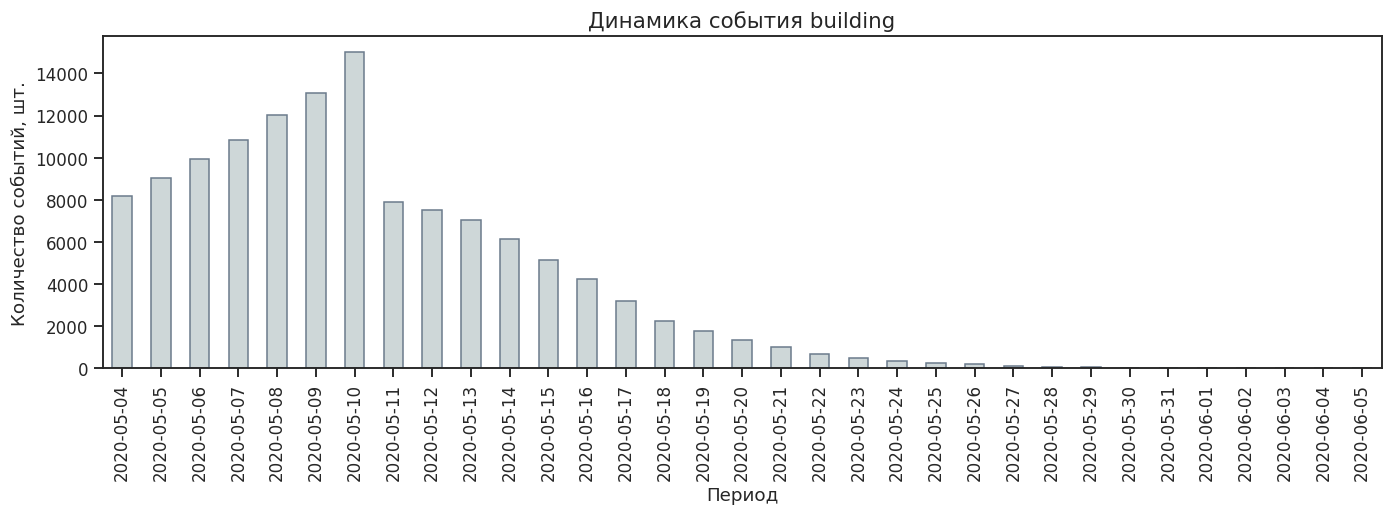

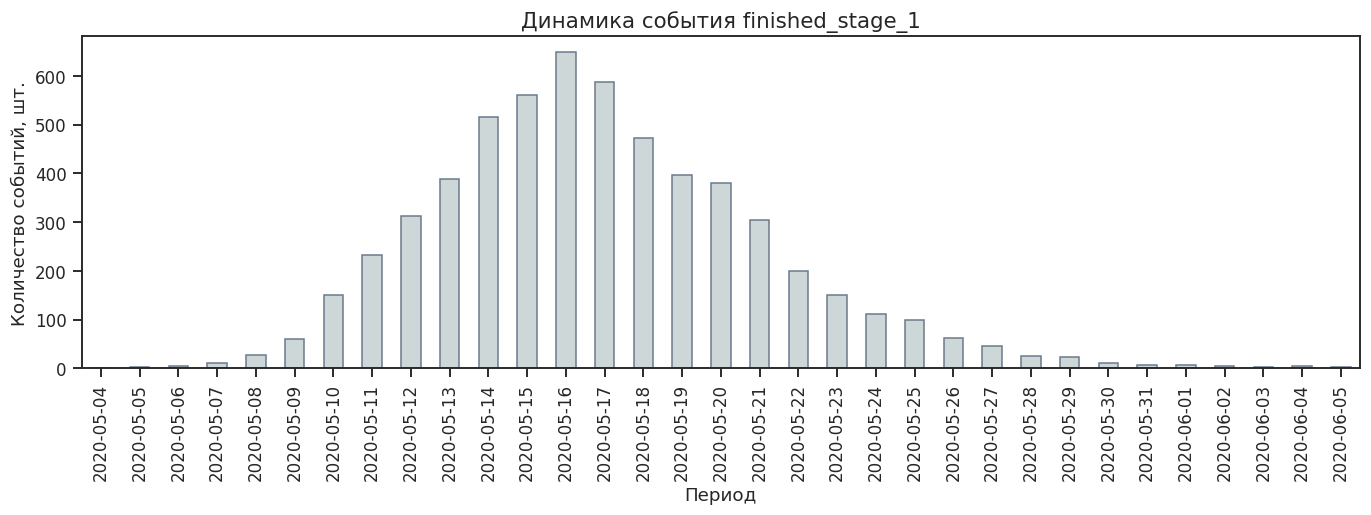

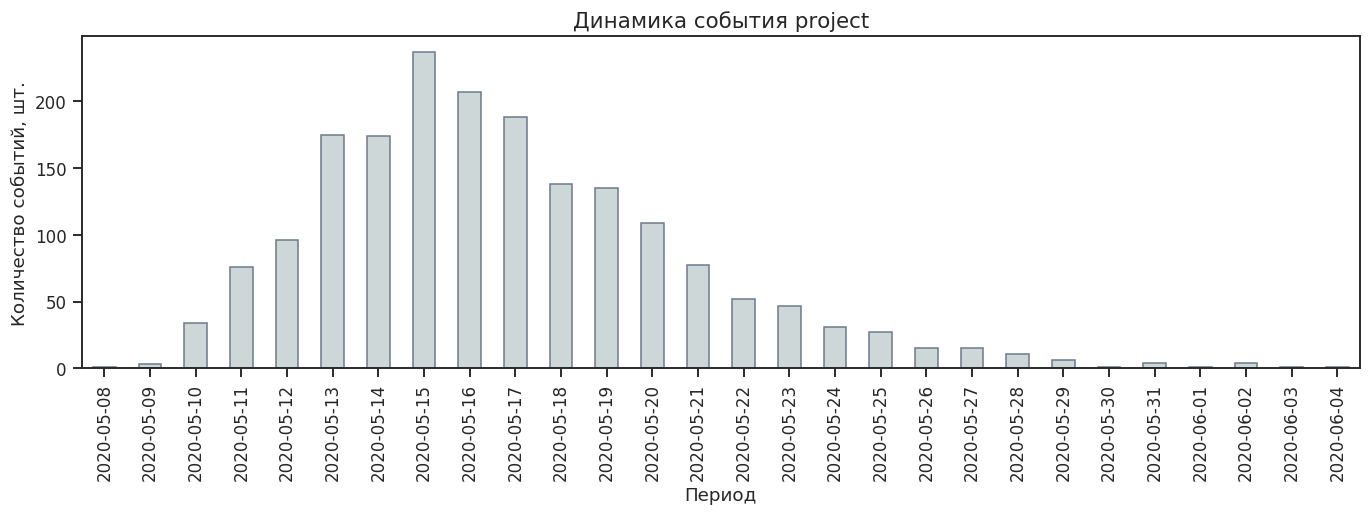

In [29]:
for i in game_actions['event'].unique():
    fig, axes = plt.subplots(figsize=(15, 4), dpi=110)
    (game_actions[game_actions['event'] == i].groupby('date')['user_id'].count().
     plot(kind='bar', color='#ced7d8', edgecolor='#6b7b8c'))
    plt.title('Динамика события {}'.format(i), fontsize=14)
    plt.xlabel('Период')
    plt.ylabel('Количество событий, шт.')
    plt.show()

Событие постройки распределено идентично всем событиям, что логично, учитывая, что событие данного типа занимает 94% всех событий.

Динамика события завершения первого уровня имеет распределение, похожее на нормальное, с пиком 16 мая.

Событие реализации проекта тоже довольно сильно похоже на нормальное с пиком 15 мая. Самое раннее, когда игроки реализовали проект - на пятый день после старта игры.

In [30]:
print('За анализируемый период {:.1%} уникальных пользователей завершили первый уровень'.
      format(game_actions[game_actions['event'] == 'finished_stage_1']['user_id'].nunique() / 
             game_actions['user_id'].nunique()))

За анализируемый период 42.8% уникальных пользователей завершили первый уровень


Посмотрим как распределены события постройки различных типов зданий

In [31]:
game_actions['building_type'].value_counts()

spaceport          59325
assembly_shop      54494
research_center    14137
Name: building_type, dtype: int64

In [32]:
game_actions['building_type'].value_counts(normalize=True)

spaceport         0.46
assembly_shop     0.43
research_center   0.11
Name: building_type, dtype: float64

Количество построек спейспорта и сборочного цеха примерно одинаково на первом уровне (46% и 43% соответственно), а вот исследовательский центр - это лишь каждое десятое здание. 

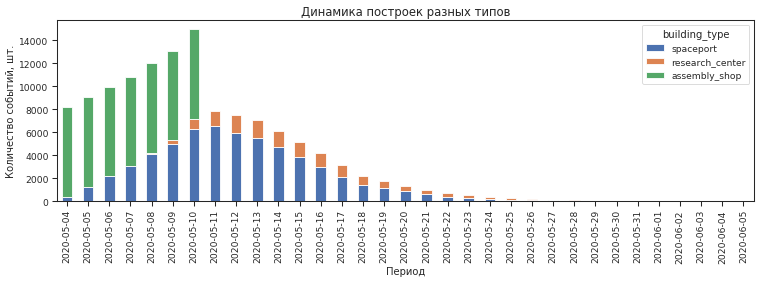

In [33]:
fig, ax=plt.subplots(figsize=(15,4), dpi=60)
df_plot = (game_actions.groupby(['building_type', 'date']).size().reset_index().
           pivot(columns='building_type', index='date', values=0))
df_plot[['spaceport', 'research_center', 'assembly_shop']].plot(kind='bar', stacked=True, ax=ax)
plt.title('Динамика построек разных типов', fontsize=14)
plt.xlabel('Период')
plt.ylabel('Количество событий, шт.')
plt.show()

Предположительно сборочный цех (assembly_shop) - одна из первых построек, которую необходимо сделать в игре. Такой тип построек был только в первую неделю с начала игры (совпадает с периодом добавления новых игроков - с 4 по 10 мая) и каждый день количество таких построек было примерно одинаково.

Распределение построек космодрома (spaceport) похоже на нормальное, пик наблюдается 11 мая, такой тип постройки был с самого начала до предпосленего дня анализируемого периода.

Строительство исследовательского центра (research_center) самое непопулярное у игроков среди всех видов построек, возможно, оно не является обязательным для продвижения по уровню или сложнореализуемо. Распределение также довольно сильно похоже на нормальное, но построено первое такое здание было на третий день с запуска игры (6 мая), вероятно, эта постройка не может осуществляться без реализованных первых двух типов.

Посмотрим на событие реализации проекта

In [34]:
# проверка: все типы проектов соответствуют событию project
len(game_actions[game_actions['event'] == 'project']) == game_actions['project_type'].notna().sum()

True

In [35]:
print('Доля завершивших проект составляет {:.1%} от всех уникальных игроков'.
      format(game_actions['project_type'].count() / game_actions['user_id'].nunique()))

Доля завершивших проект составляет 13.7% от всех уникальных игроков


In [36]:
print('На каждого игрока в среднем приходится {:.0f} проектов'.
      format(len(game_actions[game_actions['event'] == 'project']) / 
             game_actions[game_actions['event'] == 'project']['user_id'].nunique()))

На каждого игрока в среднем приходится 1 проектов


Все проекты выполнены уникальными игроками

<a id='user_source'></a>
### 2.1.2 Обзор признаков user_source

In [37]:
user_source['source'].value_counts()

yandex_direct              4817
instagram_new_adverts      3347
facebook_ads               2726
youtube_channel_reklama    2686
Name: source, dtype: int64

In [38]:
user_source['source'].value_counts(normalize=True)

yandex_direct             0.35
instagram_new_adverts     0.25
facebook_ads              0.20
youtube_channel_reklama   0.20
Name: source, dtype: float64

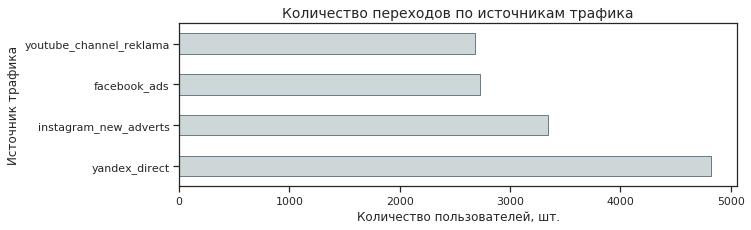

In [39]:
user_source['source'].value_counts().plot(kind='barh', figsize=(10,3), color='#ced7d8', edgecolor='#6b7b8c')
plt.title('Количество переходов по источникам трафика', fontsize=14)
plt.ylabel('Источник трафика')
plt.xlabel('Количество пользователей, шт.')
plt.show()

Наиболее популярный источник - Яндекс директ (35% всех игроков пришли через него), на втором месте инстаграм (25%), у фейсбука и ютуба доля пользователей примерно одинакова (по 20%).

<a id='ad_costs'></a>
### 2.1.3 Обзор признаков ad_costs

In [40]:
ad_costs['source'].value_counts()

instagram_new_adverts      7
yandex_direct              7
youtube_channel_reklama    7
facebook_ads               7
Name: source, dtype: int64

In [41]:
ad_costs['day'].unique()

array(['2020-05-03', '2020-05-04', '2020-05-05', '2020-05-06',
       '2020-05-07', '2020-05-08', '2020-05-09'], dtype=object)

В каждом из источников реклама публиковалась в течение 7 дней с 3 по 9 мая (рекламу начали показывать на день раньше, чем запустилась игра)

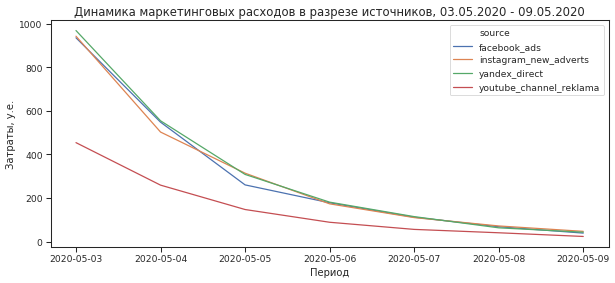

In [42]:
plt.figure(figsize=(12,5), dpi=60)
sns.lineplot(data = ad_costs, x='day', y='cost', hue='source')
plt.title('Динамика маркетинговых расходов в разрезе источников, 03.05.2020 - 09.05.2020', fontsize=14)
plt.xlabel('Период')
plt.ylabel('Затраты, у.е.')
plt.show()

Наибольшие затраты наблюдались перед стартом игры по каждому из источников. Затраты на фейсбук, инстаграм и яндекс почти идентичны, затраты на ютуб значительно ниже, почти вполовину стоимости любого из остальных источников, но также имеют тенденцию к снижению с течением времени.

In [43]:
print('Итого затраты на маркетинг {:.2f} у.е.'.format(ad_costs['cost'].sum()))

Итого затраты на маркетинг 7603.58 у.е.


Соберем суммарные затраты на маркетинг по дням.

In [44]:
costs_by_day = ad_costs.groupby('day')['cost'].sum()
costs_by_day

day
2020-05-03   3302.45
2020-05-04   1865.00
2020-05-05   1029.43
2020-05-06   620.48 
2020-05-07   391.85 
2020-05-08   242.77 
2020-05-09   151.59 
Name: cost, dtype: float64

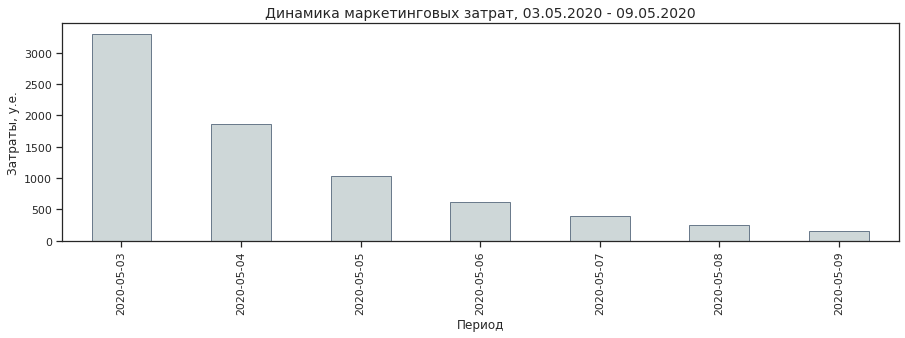

In [45]:
costs_by_day.plot(kind='bar', figsize=(15,4), color='#ced7d8', edgecolor='#6b7b8c')
plt.title('Динамика маркетинговых затрат, 03.05.2020 - 09.05.2020', fontsize=14)
plt.xlabel('Период')
plt.ylabel('Затраты, у.е.')
plt.show()

Затраты на маркетинг уменьшаются день ото дня после запуска игры, в каждый следующий день затраты  примерно вдвое меньше, чем в предыдущий день.

In [46]:
ad_costs.groupby('source')['cost'].sum()

source
facebook_ads              2140.90
instagram_new_adverts     2161.44
yandex_direct             2233.11
youtube_channel_reklama   1068.12
Name: cost, dtype: float64

In [47]:
ad_costs.groupby('source')['cost'].sum() / ad_costs['cost'].sum()

source
facebook_ads              0.28
instagram_new_adverts     0.28
yandex_direct             0.29
youtube_channel_reklama   0.14
Name: cost, dtype: float64

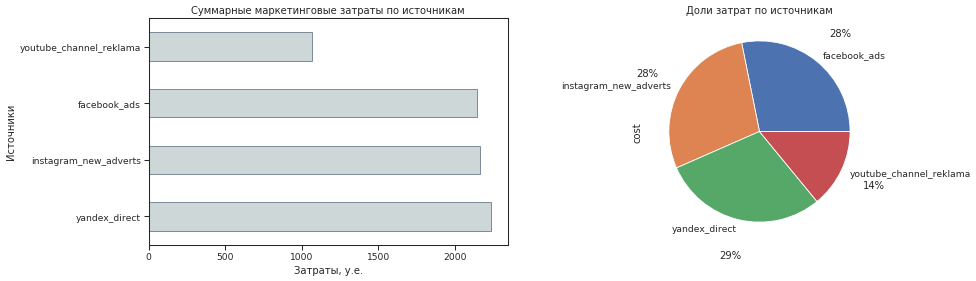

In [48]:
#fixed
fig, axes = plt.subplots(1, 2, figsize=(17, 5), dpi=60)

ad_costs.groupby('source')['cost'].sum().sort_values(ascending=False).plot(kind='barh', 
                    color='#ced7d8', edgecolor='#6b7b8c', ax=axes[0])
axes[0].set_title('Суммарные маркетинговые затраты по источникам')
axes[0].set_ylabel('Источники')
axes[0].set_xlabel('Затраты, у.е.')

(ad_costs.groupby('source')['cost'].sum() / 
 ad_costs['cost'].sum()).plot(kind='pie', ax=axes[1],
        autopct='%1.0f%%', pctdistance=1.4, labeldistance=1.1)
axes[1].set_title('Доли затрат по источникам')
plt.show()

Суммарные затраты в разрезе источников подтверждают ранее обозначеннную тенденцию - 3 из 4 источников имеют почти идентичные затраты (доля 28-29%), а реклама на Ютубе стоила почти в 2 раза меньше, чем в остальных источниках (занимает 14% суммарного бюджета).

<a id='feature_distribution_churn'></a>
### 2.2 Обзор распределения признаков по группам завершивших и не завершивших уровень

<a id='events_by_users'></a>
### 2.2.1 Создание датафрейма с данными по уникальным игрокам events_by_users

Для проведения анализа пользовательского поведения создадим датафрейм по уникальным игрокам, добавив информацию:
* дата первого события
* дата последнего события
* дата завершения проекта
* дата завершения уровня
* флаг завершения уровня
* количество дней на завершение уровня
* количество дней в игре
* количество построек
* флаг завершения уровня через проект

In [49]:
events_by_users = user_source.merge(
    game_actions.sort_values(by=['user_id', 'date']).groupby('user_id')['date'].first(),
on='user_id', how='left')
events_by_users = events_by_users.rename(columns={'date':'first_date'})

In [50]:
events_by_users = events_by_users.merge(
    game_actions.sort_values(by=['user_id', 'date']).groupby('user_id')['date'].last(),
on='user_id', how='left')
events_by_users = events_by_users.rename(columns={'date':'last_date'})

In [51]:
events_by_users = events_by_users.merge(
    game_actions[game_actions['event'] == 'project'].sort_values(by=['user_id', 'date'])
    .groupby('user_id')['date'].first(), on='user_id', how='left')
events_by_users = events_by_users.rename(columns={'date' : 'date_project'})

In [52]:
events_by_users = events_by_users.merge(
    game_actions[game_actions['event'] == 'finished_stage_1'].sort_values(by=['user_id', 'date'])
    .groupby('user_id')['date'].first(), on='user_id', how='left')
events_by_users = events_by_users.rename(columns={'date' : 'date_finished_stage_1'})

In [53]:
events_by_users['days_to_complete'] = (events_by_users['date_finished_stage_1'] - 
                                       events_by_users['first_date']).dt.days + 1

In [54]:
events_by_users['is_complete'] = events_by_users['date_finished_stage_1'].notna() * 1

In [55]:
events_by_users['days_in_game'] = (events_by_users['last_date'] - events_by_users['first_date']).dt.days + 1

In [56]:
events_by_users = events_by_users.merge(
    game_actions[game_actions['event'] == 'building'].groupby('user_id')['event'].count(), 
    how='left', on='user_id'
)
events_by_users = events_by_users.rename({'event': 'n_buildings'}, axis=1)

In [57]:
events_by_users['through_project'] = events_by_users['date_project'].notna() * 1

In [58]:
events_by_users.head()

,user_id,source,first_date,last_date,date_project,date_finished_stage_1,days_to_complete,is_complete,days_in_game,n_buildings,through_project
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads,2020-05-06,2020-05-20,NaN,NaN,nan,0,15,13,0
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct,2020-05-06,2020-05-18,NaN,NaN,nan,0,13,9,0
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama,2020-05-05,2020-05-14,NaN,NaN,nan,0,10,4,0
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts,2020-05-05,2020-05-12,NaN,2020-05-12,8.00,1,8,8,0
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads,2020-05-05,2020-05-22,NaN,NaN,nan,0,18,12,0


In [59]:
events_by_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13576 entries, 0 to 13575
Data columns (total 11 columns):
user_id                  13576 non-null object
source                   13576 non-null object
first_date               13576 non-null object
last_date                13576 non-null object
date_project             1866 non-null object
date_finished_stage_1    5817 non-null object
days_to_complete         5817 non-null float64
is_complete              13576 non-null int64
days_in_game             13576 non-null int64
n_buildings              13576 non-null int64
through_project          13576 non-null int64
dtypes: float64(1), int64(4), object(6)
memory usage: 1.2+ MB


<a id='is_complete'></a>
### 2.2.2 Характеристики завершаемости уровня

In [60]:
events_by_users.groupby('source')['is_complete'].mean()

source
facebook_ads              0.42
instagram_new_adverts     0.44
yandex_direct             0.42
youtube_channel_reklama   0.43
Name: is_complete, dtype: float64

По всем источникам завершили уровень примерно одинаковая доля пользователей (42-44%)

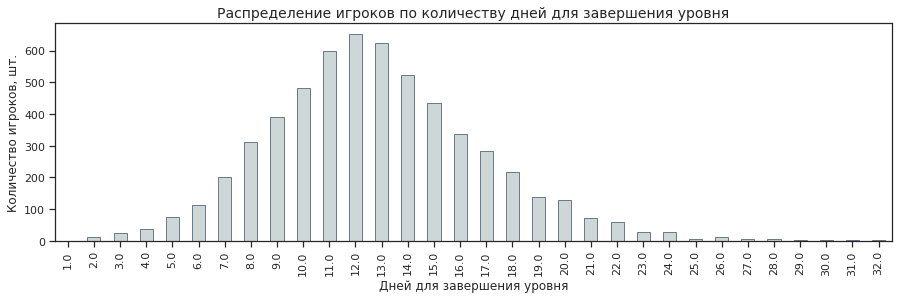

In [61]:
events_by_users.groupby('days_to_complete')['user_id'].count().plot(kind='bar', figsize=(15,4), color='#ced7d8', edgecolor='#6b7b8c')
plt.title('Распределение игроков по количеству дней для завершения уровня', fontsize=14)
plt.xlabel('Дней для завершения уровня')
plt.ylabel('Количество игроков, шт.')
plt.show()

Распределение по времени для завершения уровня очень похоже на нормальное с разбросом от 1 до 31 дня, в среднем завершение уровня происходит после 12 дней в игре. 

Посмотрим, есть ли различия в признаках у тех, кто завершил первый уровень, и нет

<a id='features_if_completed'></a>
### 2.2.3 Анализ признаков в зависимости от завершенности уровня

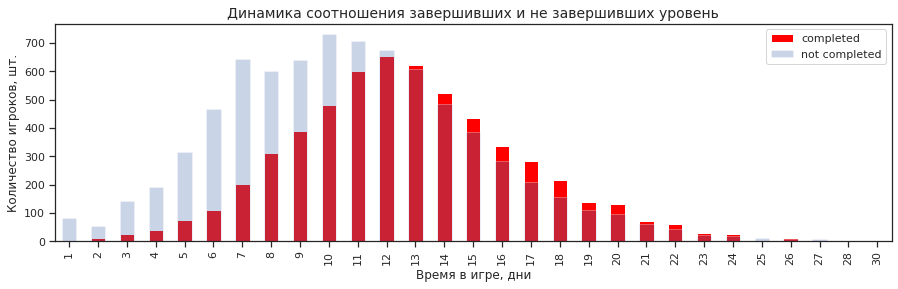

In [62]:
events_by_users[events_by_users['is_complete']==1].groupby('days_in_game')['user_id'].count().plot(kind='bar', figsize=(15,4), color='red', label='completed')
events_by_users[events_by_users['is_complete']==0].groupby('days_in_game')['user_id'].count().plot(kind='bar', figsize=(15,4), alpha=0.3, label='not completed')
plt.legend()
plt.title('Динамика соотношения завершивших и не завершивших уровень', fontsize=14)
plt.xlabel('Время в игре, дни')
plt.ylabel('Количество игроков, шт.')
plt.show()

В первые двенадцать дней каждый день уходят большее количество игроков, не завершивших уровень. Причем на 7 день виден всплеск среди ушедших и не завершивших, возможно это такой некий испытательный срок, который дают игроки новой игре. К 12-му дню соотношение завершивших и не завершивших уровень примерно сравнивается и продолжает быть таким до конца периода, но все же после 12го дня большинство игроков ежедневно покидают первый уровень после его завершения.

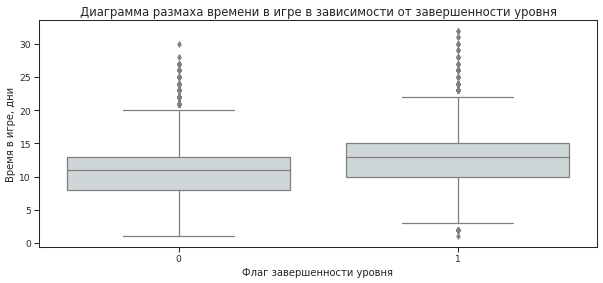

In [63]:
plt.figure(figsize=(12,5), dpi=60)
sns.boxplot(data = events_by_users, y='days_in_game', x='is_complete', color='#ced7d8')
plt.title('Диаграмма размаха времени в игре в зависимости от завершенности уровня', fontsize=14)
plt.xlabel('Флаг завершенности уровня')
plt.ylabel('Время в игре, дни')
plt.show()

In [64]:
events_by_users.groupby('is_complete')['days_in_game'].mean()

is_complete
0   10.75
1   12.81
Name: days_in_game, dtype: float64

В среднем те, кто завершают первый уровень, проводят в игре на 2 дня больше (12.8 против 10.8). 

<a id='analysis_conclusion'></a>
## Вывод по пункту 2

Логи содержат данные за период чуть больше месяца (с 04 мая по 5 июня 2020г). В них содержатся данные об игроках, которые начали пользоваться игрой в период с 4 по 10 мая включительно.

Пик событий приходится на 10 мая, количество игроков на пике: 9219. После 10 мая количество событий как и количество уникальных игроков начинает уменьшаться день ото дня, вероятно, часть игроков проходят уровень, а часть игроков покидает игру.

На одного игрока в среднем приходится 1.3 событий в день, 10 событий за весь период. Преимущественно игроки возводят постройки (94% всех событий); завершение первого уровня - 4% событий (42.8% уникальных пользователей завершили первый уровень), 1% - осуществление проекта (доля игроков завершивших проект составляет 13.7%).

Количество построек спейспорта и сборочного цеха примерно одинаково на первом уровне (46% и 43% соответственно), а вот исследовательский центр - это лишь каждое десятое здание. 

Сборочный цех (assembly_shop) - одна из первых построек, которую необходимо сделать в игре, присутствует только в первую неделю с начала игры. 
Космодромы (spaceport) строят с самого начала до предпосленего дня анализируемого периода.
Строительство исследовательского центра (research_center) самое непопулярное у игроков, первая постройка такого типа - 6 мая, вероятно, она не может осуществляться без построенных assembly_shop и spaceport.
В случае показа рекламы в момент постройки лучше ориентроваться на spaceport, так как это самый популярный вид постройки и присутствует на всем протяжении анализируемого периода.

Наиболее популярный источник - Яндекс директ (35% всех игроков пришли чере него), в каждом из источников реклама публиковалась в течение 7 дней с 3 по 9 мая, наибольшие затраты наблюдались перед стартом игры по каждому из источников. Итого затраты на маркетинг составили 7603.58 у.е.

По всем источникам завершили уровень примерно одинаковая доля пользователей (наименьшее у Фейсбук и Яндекса 42%, наибольшее у Инстаграм - 44%). В среднем игрокам нужно 12 дней, чтобы закончить первый уровень. В среднем те, кто завершают первый уровень, проводят в игре на 2 дня больше.

Самое раннее, когда игрокам удается завершить игру - на второй день с момента запуска, в первые двенадцать дней каждый день уходят большее количество игроков, не завершивших уровень. Максимальный отток происходит на 10-11 день. 

<a id='source_analysis'></a>
## 3 Анализ влияния источника перехода в игру на поведение пользователя

<a id='user_path'></a>
### 3.1 Пользовательские пути внутри игры

Ранее нами были добавлены шаги, которые доступны игрокам на первом уровне игры "Космические братья"

In [65]:
game_actions['steps'].value_counts()

spaceport                     59325
assembly_shop                 54494
research_center               14137
finished_stage_1              5817 
satellite_orbital_assembly    1866 
Name: steps, dtype: int64

Выстроим эти шаги в цепочку шагов и посмотрим наиболее популярные стратегии среди игроков, а также добавим информацию по количеству дней в игре на каждого игрока

In [66]:
steps_seq = (game_actions.groupby('user_id')['steps'].
             apply(lambda event: ', '.join(event.values)).reset_index(name='event_seq'))

In [67]:
steps_seq = steps_seq.merge(events_by_users[['user_id', 'days_in_game']], how='left', on='user_id')

In [68]:
top_steps = (steps_seq.groupby('event_seq').
             agg({'user_id':'count', 'days_in_game':'median'}).
             reset_index().sort_values(by='user_id', ascending=False))

In [69]:
top_steps.head()

,event_seq,user_id,days_in_game
5632,"assembly_shop, spaceport, spaceport",213,7.00
5879,"assembly_shop, spaceport, spaceport, spaceport, spaceport",200,10.00
5831,"assembly_shop, spaceport, spaceport, spaceport",196,8.00
5904,"assembly_shop, spaceport, spaceport, spaceport, spaceport, spaceport",189,11.00
4844,"assembly_shop, spaceport",181,4.00


Посмотрим на топ-10 стратегий среди тех, кто прошел уровень

In [70]:
top_steps[top_steps['event_seq'].str.contains('finished_stage_1')].head(10)

,event_seq,user_id,days_in_game
5909,"assembly_shop, spaceport, spaceport, spaceport, spaceport, spaceport, finished_stage_1",58,11.00
5631,"assembly_shop, spaceport, finished_stage_1",49,5.00
5878,"assembly_shop, spaceport, spaceport, spaceport, finished_stage_1",48,8.00
5830,"assembly_shop, spaceport, spaceport, finished_stage_1",47,7.00
5903,"assembly_shop, spaceport, spaceport, spaceport, spaceport, finished_stage_1",46,11.00
3168,"assembly_shop, assembly_shop, assembly_shop, spaceport, spaceport, finished_stage_1",42,8.00
4360,"assembly_shop, assembly_shop, spaceport, finished_stage_1",42,6.50
5913,"assembly_shop, spaceport, spaceport, spaceport, spaceport, spaceport, spaceport, research_center, finished_stage_1",38,14.00
4580,"assembly_shop, assembly_shop, spaceport, spaceport, finished_stage_1",38,8.00
2009,"assembly_shop, assembly_shop, assembly_shop, assembly_shop, spaceport, spaceport, finished_stage_1",38,10.00


Топовые стратегии победы основаны не на завершении проекта. В топе нет ни одной последовательности, где была бы реализована победа через проект.     
Основные шаги в топовых стратегиях: assembly shop, от 1 до 5 spaceport и завершение уровня через победу над врагом.    
Топовые стратегии заставляют быть в игре разное количество времени, но чем больше построек, тем длительность в игре больше (в среднем 2 дня на 1 постройку)

In [71]:
print('Доля прошедших уровень через проект от всех завершивших первый уровень: {:.0%}'
.format(len(game_actions[game_actions['event'] == 'project']) / 
        len(game_actions[game_actions['event'] == 'finished_stage_1'])))

Доля прошедших уровень через проект от всех завершивших первый уровень: 32%


Посмотрим на топ-10 стратегий среди тех, кто НЕ прошел уровень

In [72]:
top_steps[~top_steps['event_seq'].str.contains('finished_stage_1')].head(10)

,event_seq,user_id,days_in_game
5632,"assembly_shop, spaceport, spaceport",213,7.00
5879,"assembly_shop, spaceport, spaceport, spaceport, spaceport",200,10.00
5831,"assembly_shop, spaceport, spaceport, spaceport",196,8.00
5904,"assembly_shop, spaceport, spaceport, spaceport, spaceport, spaceport",189,11.00
4844,"assembly_shop, spaceport",181,4.00
3452,"assembly_shop, assembly_shop, spaceport",171,6.00
2231,"assembly_shop, assembly_shop, assembly_shop, spaceport",151,7.00
4653,"assembly_shop, assembly_shop, spaceport, spaceport, spaceport, spaceport",147,10.00
4361,"assembly_shop, assembly_shop, spaceport, spaceport",143,8.00
721,"assembly_shop, assembly_shop, assembly_shop, assembly_shop, assembly_shop, spaceport",140,8.00


In [73]:
# проверка: все, кто завершил уровень через проект, имели постройку research_center
(len((events_by_users[(events_by_users['date_project'].notna())]['user_id'].reset_index()).
    merge(game_actions[game_actions['building_type'] == 'research_center']['user_id'].
          drop_duplicates(), how='left')['index'].notna()) 
== len((events_by_users[(events_by_users['date_project'].notna())])))

True

В основном бросают игру построив assembly_shop и несколько spaceport-ов. Вероятно, эти игроки хотели бы завершить уровень победой, но не смогли победить соперника и мотивация играть пропала.

Поскольку меньше половины завершивших уровень игроков осуществили этот этап через проект (32%), напрашивается вывод о том, что механика реализации проекта является сложной и непривлекательной стратегией для игроков. При этом среди не завершивших уровень в топовых стратегиях нет даже тех, кто бы строил research_center, то есть эти игроки даже не стали пытаться идти по пути реализации проекта (среди тех, кто завершил уровень через проект, у всех была постройка research_center, видимо, это обязательный этап для завершения проекта). Стоило бы более внимательно посмотреть на баланс в игре в области строительства research_center и реализации проекта первого уровня.

<a id='distribution_of_players'></a>
### 3.2 Анализ источников перехода в игру

In [74]:
game_actions = (game_actions.merge(events_by_users[['user_id', 'source']], 
                                   how='left', on='user_id'))

Сформируем когорты по источникам перехода в игру и посмотрим какое число пользователей ежедневно заходит в игру в зависимости от источника

In [75]:
cohorts_source = (game_actions.
 pivot_table(index='date', columns='source', values='user_id', aggfunc='nunique'))

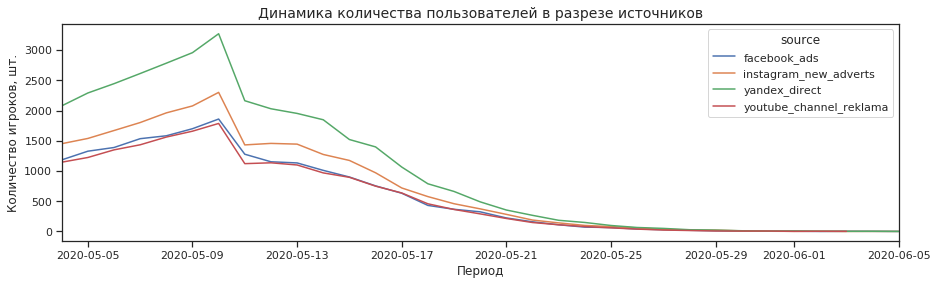

In [76]:
ax = plt.subplot()
cohorts_source.plot(figsize=(15,4), ax=ax)
plt.title('Динамика количества пользователей в разрезе источников', fontsize=14)
plt.xlabel('Период')
plt.ylabel('Количество игроков, шт.')
plt.show()

Добавим в основной датафрейм game_actions данные по максимальному числу игроков в разрезе источников

In [77]:
game_actions = game_actions.merge(
    game_actions.pivot_table(index='date', columns='source', values='user_id', aggfunc='nunique').
    max().reset_index(), how='left', on='source'
)
game_actions = game_actions.rename(columns={0:'max_users_on_source'})

Посчитаем долю игроков в каждый день от максимального числа пришедших из источника

In [78]:
cohorts_source / (game_actions.
 pivot_table(index='date', columns='source', values='max_users_on_source', aggfunc='mean'))

source,facebook_ads,instagram_new_adverts,yandex_direct,youtube_channel_reklama
date,,,,
2020-05-04,0.64,0.63,0.64,0.64
2020-05-05,0.71,0.67,0.70,0.68
2020-05-06,0.75,0.73,0.75,0.76
2020-05-07,0.83,0.78,0.80,0.80
2020-05-08,0.85,0.85,0.85,0.87
2020-05-09,0.91,0.90,0.90,0.93
2020-05-10,1.00,1.00,1.00,1.00
2020-05-11,0.69,0.62,0.66,0.63
2020-05-12,0.62,0.63,0.62,0.64


Наиболее популярный источник, как уже было выявлено ранее, это Яндекс Директ. Наибольшее число игроков по каждому из источников наблюдается на 7й день (10.05.2021). В целом тенденция добавления игроков в разных кластерах примерно идентична что на старте, когда каждый день добавляются новые игроки в течение недели, что после пика, коогда ежедневно идет уменьшение игроков, частично завершающих уровень, частично уходящих из игры. Спустя 3 недели остается меньше 5% игроков от пика и оставшиеся дни количество игроков совсем незначительное.

<a id='clusters'></a>
### 3.3 Типичное поведение игроков в зависимости от источника перехода

Посмотрим на характеристики поведения игроков в зависимости от источника перехода в игру

In [79]:
(events_by_users[events_by_users['days_to_complete'].notna()]
 .groupby('source').agg({'days_to_complete':['mean', 'median']}))

days_to_complete       
                                    mean median
source                                         
facebook_ads            12.79            13.00 
instagram_new_adverts   12.85            13.00 
yandex_direct           12.76            12.00 
youtube_channel_reklama 12.86            13.00

В среднем игроки завершают первый уровень на 13й день. Медианное значение составляет 13 дней по всем источникам, кроме Яндекса, здесь игрокам достаточно 12 дней.

In [80]:
events_by_users.pivot_table(index='source', columns='is_complete', 
                            values=['days_in_game'], aggfunc=['mean', 'median'])

mean             median    
                        days_in_game       days_in_game    
is_complete                        0     1            0   1
source                                                     
facebook_ads            10.86        12.79  11           13
instagram_new_adverts   10.89        12.85  11           13
yandex_direct           10.69        12.76  10           12
youtube_channel_reklama 10.56        12.86  10           13

У типичных игороков, пришедших через Ютуб, и завершивших первый уровень, время в игре было на 3 дня дольше, чем у не завершивших. У всех остальных источников эта разница составляла 2 дня.

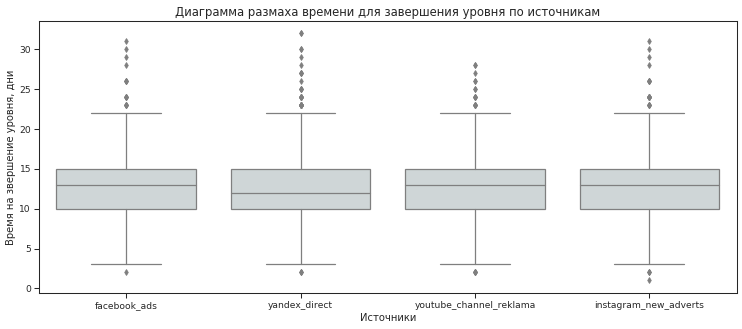

In [81]:
plt.figure(figsize=(15,6), dpi=60)
sns.boxplot(data = events_by_users, y='days_to_complete', x='source', color='#ced7d8')
plt.title('Диаграмма размаха времени для завершения уровня по источникам', fontsize=14)
plt.xlabel('Источники')
plt.ylabel('Время на звершение уровня, дни')
plt.show()

Среднее время на завершение уровня не зависит от источника, наименьший разброс времени у пришедших с Ютуба

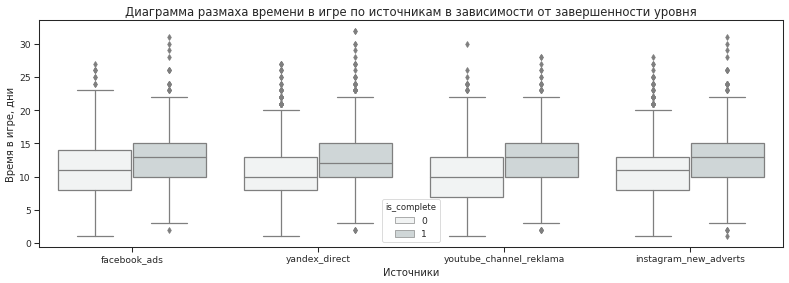

In [82]:
plt.figure(figsize=(16,5), dpi=60)
sns.boxplot(data = events_by_users, y='days_in_game', x='source', hue='is_complete', color='#ced7d8')
plt.title('Диаграмма размаха времени в игре по источникам в зависимости от завершенности уровня', fontsize=14)
plt.xlabel('Источники')
plt.ylabel('Время в игре, дни')
plt.show()

По всем источникам наблюдается тенденция более длительного пребывания в игре в случае завершения первого уровня, при этом у пришедших с Ютуба эта разница между группами наибольшая.

Посмотрим на распределение времени в игре прошедших и не прошедших уровень по каждому из источников

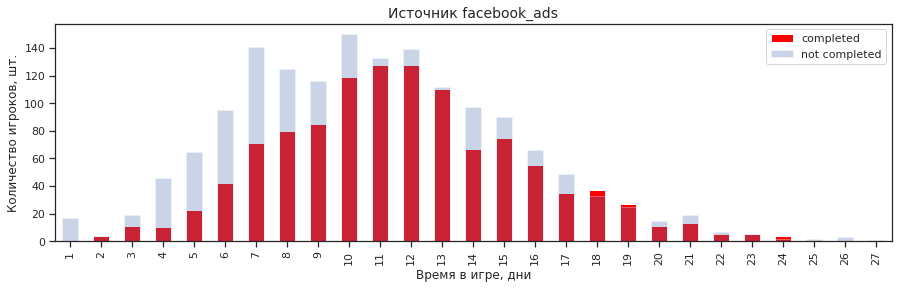

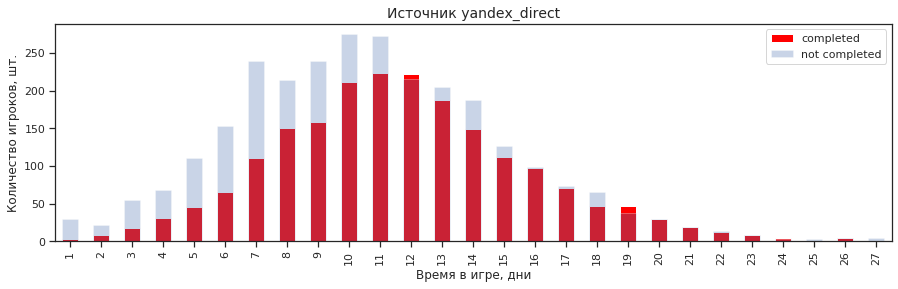

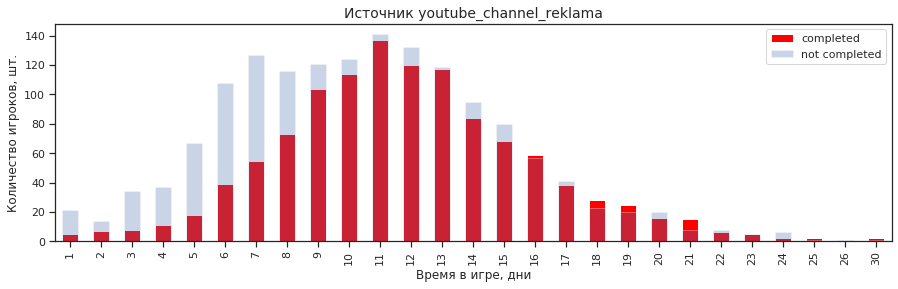

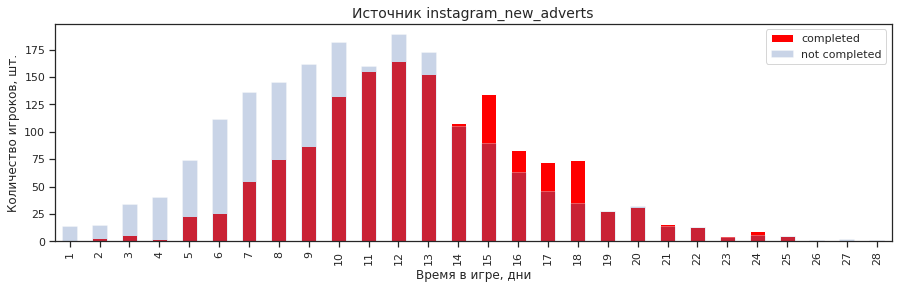

In [83]:
for i in user_source['source'].unique():
    
    (events_by_users[(events_by_users['is_complete']==1) & (events_by_users['source'] == i)].
     groupby('days_in_game')['user_id'].count().
     plot(kind='bar', figsize=(15,4), color='red', label='completed'))
    
    (events_by_users[(events_by_users['is_complete']==0) & (events_by_users['source'] == i)].
     groupby('days_in_game')['user_id'].count().
     plot(kind='bar', figsize=(15,4), alpha=0.3, label='not completed'))
    
    plt.legend()
    plt.title('Источник ' + i, fontsize=14)
    plt.xlabel('Время в игре, дни')
    plt.ylabel('Количество игроков, шт.')
    plt.show()

Тенденцию в целом по всем игрокам повторяют только пользователи Инстаграм, но переход к большинству уходящих после завершения уровеня происходит только на 14 день.

По остальным трем источникам ежедневно преимущественно уходят те, кто уровень не завершил, причем также по всем трем источникам на 7 день мы видим всплеск тех, кто не завершил, по отношению к прошедшим уровень. Максимальный отток происходит на 10-11 день.

Посмотрим, сколько дней проводят в игре те, кто завершил уровень через проект, и все остальные в разрезе источников.

In [84]:
events_by_users[events_by_users['is_complete'] == 1].pivot_table(index='source', columns='through_project', 
                            values=['days_in_game'], aggfunc=['mean', 'median'])

mean             median    
                        days_in_game       days_in_game    
through_project                    0     1            0   1
source                                                     
facebook_ads            12.00        14.35  12           14
instagram_new_adverts   12.07        14.47  12           14
yandex_direct           12.08        14.32  12           14
youtube_channel_reklama 12.07        14.49  12           14

Во всех источниках те, кто завершают уровень через проект, проводят на первом уровне больше времени.

In [85]:
events_by_users.groupby('source')['through_project'].mean() * 100

source
facebook_ads              14.34
instagram_new_adverts     14.22
yandex_direct             12.87
youtube_channel_reklama   14.11
Name: through_project, dtype: float64

Пришедшие через яндекс игроки завершают через проект 12,9% от всех юзеров, в остальных источниках 14%+.

In [86]:
events_by_users[events_by_users['is_complete'] == 1].groupby('source')['through_project'].mean()

source
facebook_ads              0.34
instagram_new_adverts     0.32
yandex_direct             0.30
youtube_channel_reklama   0.33
Name: through_project, dtype: float64

Среди завершивших уровень: через яндекс завершают через проект 30% от всех юзеров, в остальных источниках 32%-34%

In [87]:
events_by_users.groupby('source')['days_to_complete'].agg(['mean', 'median'])

,mean,median
source,,
facebook_ads,12.79,13.00
instagram_new_adverts,12.85,13.00
yandex_direct,12.76,12.00
youtube_channel_reklama,12.86,13.00


Быстрее всех уровень завершают те, кто пришел через яндекс директ

Посмотрим на распределение количества построек в разрезе источников

In [88]:
events_by_users.groupby('source')['n_buildings'].agg(['mean', 'median'])

,mean,median
source,,
facebook_ads,9.59,10
instagram_new_adverts,9.51,10
yandex_direct,9.35,10
youtube_channel_reklama,9.30,10


Вне зависимости от источника на каждого игрока приходится в среднем 10 построек на первом уровне

Посмотрим на популярные пути игроков в зависимости от источника перехода в игру

In [89]:
steps_seq_by_source = (steps_seq.merge(events_by_users[['user_id', 'source']], how='left', on='user_id').
 groupby(['source', 'event_seq']).agg({'user_id':'count', 'days_in_game':'median'}).reset_index()
)

In [90]:
steps_seq_by_source = steps_seq_by_source.sort_values(by='user_id', ascending=False)

In [91]:
for source in user_source['source'].unique():
    display(steps_seq_by_source[steps_seq_by_source['source'] == source].head())

,source,event_seq,user_id,days_in_game
1603,facebook_ads,"assembly_shop, spaceport, spaceport, spaceport",52,8.00
1620,facebook_ads,"assembly_shop, spaceport, spaceport, spaceport, spaceport, spaceport",46,10.50
1614,facebook_ads,"assembly_shop, spaceport, spaceport, spaceport, spaceport",41,10.00
1546,facebook_ads,"assembly_shop, spaceport, spaceport",38,7.00
1322,facebook_ads,"assembly_shop, spaceport",36,5.00


,source,event_seq,user_id,days_in_game
6055,yandex_direct,"assembly_shop, spaceport, spaceport",76,7.00
5167,yandex_direct,"assembly_shop, assembly_shop, spaceport",71,6.00
6164,yandex_direct,"assembly_shop, spaceport, spaceport, spaceport, spaceport",66,10.00
5750,yandex_direct,"assembly_shop, spaceport",65,4.00
6176,yandex_direct,"assembly_shop, spaceport, spaceport, spaceport, spaceport, spaceport",63,10.00


,source,event_seq,user_id,days_in_game
7699,youtube_channel_reklama,"assembly_shop, spaceport, spaceport",54,7.00
7496,youtube_channel_reklama,"assembly_shop, spaceport",41,3.00
7760,youtube_channel_reklama,"assembly_shop, spaceport, spaceport, spaceport, spaceport",40,8.50
6844,youtube_channel_reklama,"assembly_shop, assembly_shop, assembly_shop, spaceport",38,7.00
7747,youtube_channel_reklama,"assembly_shop, spaceport, spaceport, spaceport",35,9.00


,source,event_seq,user_id,days_in_game
3580,instagram_new_adverts,"assembly_shop, spaceport, spaceport, spaceport, spaceport",53,10.00
3588,instagram_new_adverts,"assembly_shop, spaceport, spaceport, spaceport, spaceport, spaceport",47,10.00
3560,instagram_new_adverts,"assembly_shop, spaceport, spaceport, spaceport",46,8.00
3503,instagram_new_adverts,"assembly_shop, spaceport, spaceport",45,7.00
2841,instagram_new_adverts,"assembly_shop, assembly_shop, spaceport",42,7.00


В топ-5 самых популярных стратегиях во всех источниках нет стратегии, завершающий первый уровень. После постройки assembly_shop и от 1 до 5 spaceport-ов игроки покидают игру. 

In [92]:
for source in user_source['source'].unique():
    display(steps_seq_by_source[(steps_seq_by_source['event_seq'].str.contains('finished_stage_1')) & 
                               (steps_seq_by_source['source'] == source)].head()) 

,source,event_seq,user_id,days_in_game
1613,facebook_ads,"assembly_shop, spaceport, spaceport, spaceport, finished_stage_1",11,8.00
882,facebook_ads,"assembly_shop, assembly_shop, assembly_shop, spaceport, spaceport, spaceport, finished_stage_1",10,11.00
866,facebook_ads,"assembly_shop, assembly_shop, assembly_shop, spaceport, spaceport, finished_stage_1",10,8.00
1622,facebook_ads,"assembly_shop, spaceport, spaceport, spaceport, spaceport, spaceport, finished_stage_1",10,9.00
519,facebook_ads,"assembly_shop, assembly_shop, assembly_shop, assembly_shop, spaceport, finished_stage_1",9,8.00


,source,event_seq,user_id,days_in_game
6178,yandex_direct,"assembly_shop, spaceport, spaceport, spaceport, spaceport, spaceport, finished_stage_1",23,12.00
6175,yandex_direct,"assembly_shop, spaceport, spaceport, spaceport, spaceport, finished_stage_1",21,11.00
5533,yandex_direct,"assembly_shop, assembly_shop, spaceport, finished_stage_1",20,6.00
6163,yandex_direct,"assembly_shop, spaceport, spaceport, spaceport, finished_stage_1",18,9.00
3835,yandex_direct,"assembly_shop, assembly_shop, assembly_shop, assembly_shop, assembly_shop, assembly_shop, spaceport, research_center, finished_stage_1",16,10.00


,source,event_seq,user_id,days_in_game
7767,youtube_channel_reklama,"assembly_shop, spaceport, spaceport, spaceport, spaceport, spaceport, finished_stage_1",12,12.00
7698,youtube_channel_reklama,"assembly_shop, spaceport, finished_stage_1",12,3.00
7746,youtube_channel_reklama,"assembly_shop, spaceport, spaceport, finished_stage_1",10,7.00
7759,youtube_channel_reklama,"assembly_shop, spaceport, spaceport, spaceport, finished_stage_1",10,8.00
7417,youtube_channel_reklama,"assembly_shop, assembly_shop, spaceport, spaceport, finished_stage_1",9,8.00


,source,event_seq,user_id,days_in_game
3559,instagram_new_adverts,"assembly_shop, spaceport, spaceport, finished_stage_1",18,7.00
2730,instagram_new_adverts,"assembly_shop, assembly_shop, assembly_shop, spaceport, spaceport, finished_stage_1",15,10.00
3587,instagram_new_adverts,"assembly_shop, spaceport, spaceport, spaceport, spaceport, finished_stage_1",13,10.00
3591,instagram_new_adverts,"assembly_shop, spaceport, spaceport, spaceport, spaceport, spaceport, finished_stage_1",13,9.00
3502,instagram_new_adverts,"assembly_shop, spaceport, finished_stage_1",12,6.00


В топ-5 победных стратегиях по источникам нет ни одной с завершением проекта. 

<a id='cohorts'></a>
### 3.4 Продуктовые метрики (DAU, WAU), когортный анализ по времени

In [93]:
dau = int(game_actions.groupby('date')['user_id'].nunique().mean())
dau

2884

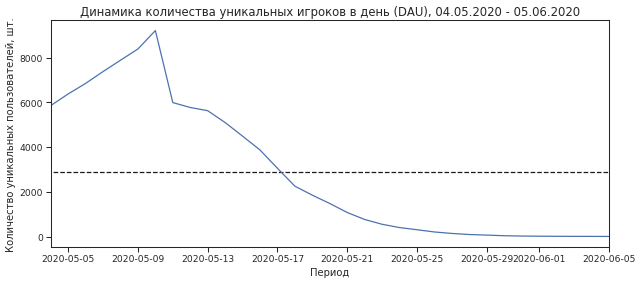

In [94]:
plt.figure(figsize=(12,5), dpi=60)
game_actions.groupby('date')['user_id'].nunique().plot()
plt.hlines(dau, 0, game_actions['date'].max(), linestyles='dashed')
plt.title('Динамика количества уникальных игроков в день (DAU), 04.05.2020 - 05.06.2020', fontsize=14)
plt.xlabel('Период')
plt.ylabel('Количество уникальных пользователей, шт.')
plt.show()

In [95]:
wau = int(game_actions.groupby(['year', 'week']).agg({'user_id' : 'nunique'}).mean())
wau

6120

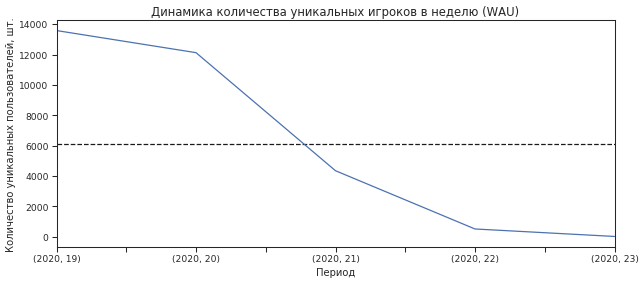

In [96]:
fig, ax = plt.subplots(figsize=(12,5), dpi=60)
game_actions.groupby(['year', 'week']).agg({'user_id' : 'nunique'}).plot(ax=ax)
ax.get_legend().remove()
plt.hlines(wau, 0, game_actions['date'].max(), linestyles='dashed')
plt.title('Динамика количества уникальных игроков в неделю (WAU)', fontsize=14)
plt.xlabel('Период')
plt.ylabel('Количество уникальных пользователей, шт.')
plt.show()

К концу первой недели количество игроков снижается примерно на 15%. После первой недели игры идет резкий спад на протяжении следующих двух недель, на последней неделе игроков уже очень мало и темп снижения вследствие этого несколько замедляется.

Посмотрим на стабильность аудитории, рассчитаем sticky factors

In [97]:
print('Sticky factor за неделю: {:.0%}'.format(dau / wau))

Sticky factor за неделю: 47%


Sticky factor за неделю на уровне 47% говорит о довольно большой вовлеченности, клиенты, которые установили игру, не спешат с ней расставаться сразу же, дают ей время на то, чтобы она смогла понравиться.

Показатель Retention Rate нельзя посчитать в классическом виде, так как часть игроков не покидают саму игру, а переходят на следующий уровень, но посмотрим на количество уникальных клиентов, которые совершали события на первом уровне, для этого сформируем когорты пользователей по дате первого события в игре, лайфтайм когорт определим по неделям.

In [98]:
(game_actions.
 pivot_table(index='first_date', columns='cohort_lifetime', values='user_id', aggfunc='nunique').
 fillna(''))

cohort_lifetime,0.00,1.00,2.00,3.00,4.00
first_date,,,,,
2020-05-04,5860.00,5761.00,3257.00,421.00,20.00
2020-05-05,3361.00,3268.00,1666.00,195.00,12.00
2020-05-06,1847.00,1750.00,810.00,104.00,6.00
2020-05-07,1109.00,1000.00,464.00,80.00,10.00
2020-05-08,688.00,610.00,270.00,33.00,2.00
2020-05-09,440.00,395.00,176.00,29.00,1.00
2020-05-10,271.00,246.00,111.00,13.00,


Размер когорт уменьшается ежедневно с начала запуска игры.    

In [99]:
cohorts = game_actions.groupby(['first_date','cohort_lifetime']).agg({'user_id':'nunique'}).reset_index()

In [100]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_date', 'user_id']]
initial_users_count = initial_users_count.rename(columns={'user_id':'cohort_users'})
cohorts = cohorts.merge(initial_users_count, on='first_date')

In [101]:
cohorts['retention'] = cohorts['user_id'] / cohorts['cohort_users']

In [102]:
retention_pivot = (cohorts.pivot_table(index='first_date', columns='cohort_lifetime', 
                                values='retention', aggfunc='sum'))

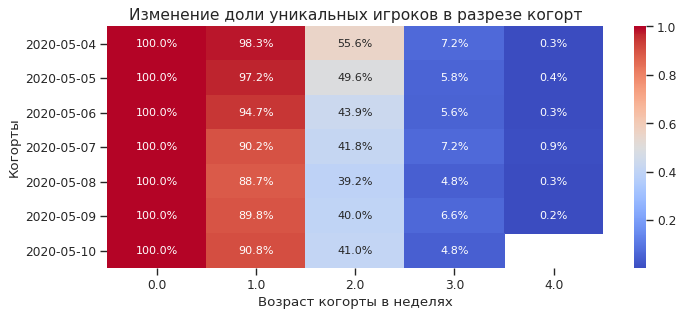

In [103]:
plt.figure(figsize=(10, 4), dpi=80)
sns.heatmap(retention_pivot, cmap= 'coolwarm', annot=True, fmt = '.1%', annot_kws={"size":10})
plt.title('Изменение доли уникальных игроков в разрезе когорт', fontsize=14)
plt.xlabel('Возраст когорты в неделях')
plt.ylabel('Когорты')
plt.show()

У когорт, сформированных в первые два дня после запуска игры, наибольшие показатели доли уникальных игроков в течение жизни когорт.   
После первой недели в игре остается до 90% игроков, на второй неделе этот показатель снижается в 2 раза и составляет 56% у самой первой когорты и 41% у последней сформированной когорты. На третьей неделе показатель еще резче падает в 7-8 раз и составляет всего 5-7% от первоначального количества игроков когорты. На 4 неделе количество игроков совсем незначительное.

<a id='romi'></a>
### 3.5 Эффективность источников (маркетинговые метрики)

Рассчитаем метрику CAC в расчете на одного игрока

In [104]:
print('Средняя стоимость привлечения одного игрока: {:.2f} у.е.'.format(
    ad_costs['cost'].sum() / len(user_source)))

Средняя стоимость привлечения одного игрока: 0.56 у.е.


Посмотрим соотношение стоимости источника и количества привлеченных игроков за весь анализируемый период.

In [105]:
cost_source_per_user = ad_costs.groupby('source')['cost'].sum() / user_source['source'].value_counts()
cost_source_per_user = cost_source_per_user.reset_index()
cost_source_per_user = cost_source_per_user.merge(user_source['source'].value_counts().reset_index())
cost_source_per_user = (cost_source_per_user.
                        rename(columns={'index':'source', 0:'cost_per_user', 'source': 'n_users'}))
cost_source_per_user

,source,cost_per_user,n_users
0,facebook_ads,0.79,2726
1,instagram_new_adverts,0.65,3347
2,yandex_direct,0.46,4817
3,youtube_channel_reklama,0.40,2686


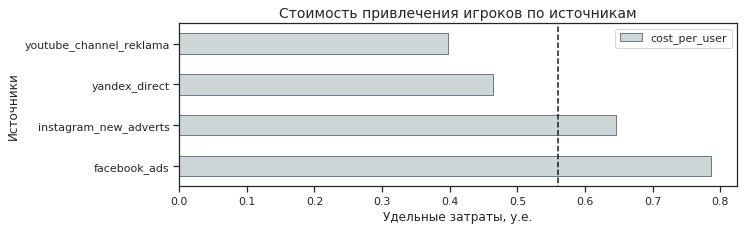

In [106]:
cost_source_per_user.plot(y='cost_per_user', x='source', kind='barh', figsize=(10,3), 
                                    color='#ced7d8', edgecolor='#6b7b8c')
plt.vlines(ad_costs['cost'].sum() / len(user_source), -1, 4, linestyles='dashed')
plt.title('Стоимость привлечения игроков по источникам', fontsize=14)
plt.ylabel('Источники')
plt.xlabel('Удельные затраты, у.е.')
plt.show()

Наиболее дешевый источник привлечения - это реклама в Ютубе, а самый затратный на одного игрока - это Фейсбук, стоимость привлечения одного игрока здесь почти в 2 раза больше, чем через Ютуб (0,4 у.е. против 0,79 у.е.), при этом оба этих канала привлекли приблизительно одинаковое количество игроков за весь анализируемый период (2686 и 2726 человек соответственно). 

Следующим после Ютуба дешевым источником стал Яндекс, причем через этот канал пришло максимальное число игроков (4817 юзеров при стоимости привлечения 0,46 у.е.). 

Инстаграм является довольно дорогим источником (0,65 у.е. на игрока), но через него пришла четверть всех игроков.

Вероятно, в Фейсбуке недостаточно большое совпадение по аудитории, которая играет в игры, подобные "Космическим братьям", поэтому удельные затраты на игрока получаются зачительными и источник выглядит наименее привлекательным. Реклама же в Яндексе является таргетированной и, скорее всего, дает наибольший эффект с точки зрения конвертации в игрока при относительно небольшой стоимости привлечения, что делает этот источник наиболее оптимальным.

Посмотрим на динамику относительной стоимости привлечения новых игроков по источникам

In [107]:
new_users = (game_actions.
             pivot_table(index='first_date', columns='source', values='user_id', aggfunc='nunique'))

In [108]:
costs_by_sources = ad_costs.pivot_table(index = 'day', columns = 'source', values='cost', aggfunc='sum') 

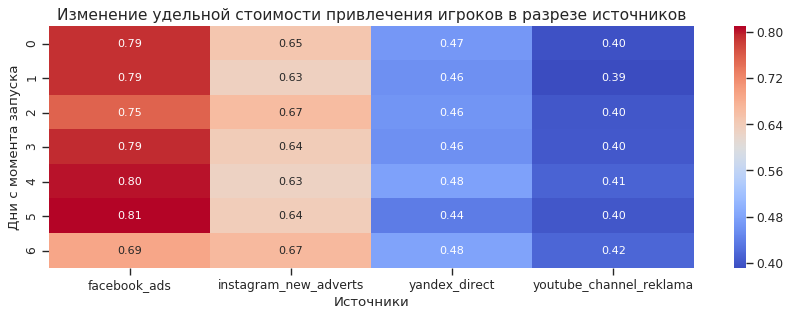

In [109]:
plt.figure(figsize=(13, 4), dpi=80)
sns.heatmap(pd.DataFrame(costs_by_sources.values / new_users.values, 
             columns=['facebook_ads', 'instagram_new_adverts', 'yandex_direct', 'youtube_channel_reklama']), 
            cmap= 'coolwarm', annot=True, fmt = '.2f', annot_kws={"size":10})
plt.title('Изменение удельной стоимости привлечения игроков в разрезе источников', fontsize=14)
plt.xlabel('Источники')
plt.ylabel('Дни с момента запуска')
plt.show()

На протяжении всех дней, когда осуществлялись вложения, мы наблюдали два относительно дорогих источника (Фейсбук и Инстаграм) и два относительно дешевых (Яндекс и Ютуб), причем удельная стоимость привлечения игрока незначительно колеблется в анализируемом периоде внутри каждого из источников. Если мы считаем, что тарифные ставки по каждому из рекламных источников не подвергались колебаниям в анализируемый период, то такая тенденция может говорить о том, что доля людей, которые становятся игроками относительно всех, кому была показана реклама, примерно постоянна в любой из дней, и слабо зависит от объема показанной рекламы, то есть охвата аудитории. В свою очередь это может быть основанием для рекомендаций по перераспределению рекламного бюджета, ведь если направить инвестиции в более эффективный источник, то можно привлечь большее количество игроков, поскольку предположительно конверсия не показывает высокой волатильности.

Для анализа рентабельности маркетинговых затрат по источникам сделаем предположение по монетизации игры и получения доходной части от показа рекламы. Предполагается, что рекламные ролики будут показываться на экране с выбором типа объекта для постройки. 

Рассчитаем точку безубыточности для общих маркетинговых затрат.

In [110]:
print('Стоимость показа рекламы на одну постройку в точке безубыточности составляет {:.2f} у.е.'.format(
ad_costs['cost'].sum() / len(game_actions[game_actions['event'] == 'building'])))

Стоимость показа рекламы на одну постройку в точке безубыточности составляет 0.06 у.е.


Учтём, что показ рекламы вызовет отток части пользователей, определим этот уровень порядка 15%, сделаем допущение о том, что этот показатель будет равномерен в течение всего периода игры на первом уровне. А также заложим доход от рекламы на уровне 10%

In [111]:
print('Заложим стоимость показа рекламы в размере {:.2f} у.е. за показ'.format(
    (ad_costs['cost'].sum() / len(game_actions[game_actions['event'] == 'building'])) / (1 - 0.15) * 1.1 ))

Заложим стоимость показа рекламы в размере 0.08 у.е. за показ


In [112]:
print('Общая сумма затрат на маркетинг: {:.2f} у.е.'.format(ad_costs['cost'].sum()))

Общая сумма затрат на маркетинг: 7603.58 у.е.


Рассчитаем в какой из дней выручка от показа рекламы на экране с выбором типа постройки превысит суммарные инвестиции в маркетинг

In [113]:
cumsum_revenue = (game_actions.groupby('date')['building_type'].count() * 0.08).cumsum().reset_index()
cumsum_revenue = cumsum_revenue.rename(columns={'building_type':'cumsum_revenue'})

In [114]:
cumsum_revenue[cumsum_revenue['cumsum_revenue'] > ad_costs['cost'].sum()].head(1)

,date,cumsum_revenue
9,2020-05-13,8044.24


Если реклама будет показываться игрокам на экране с выбором типа постройки, то на десятый день со старта игры инвестиции в маркетинг окупятся при выбранной стоимости в размере 0.08 у.е. Этот срок окупаемости можно считать приемлемым, так как на прохождение уровня игрокам в среднем нужно 12 дней, а активность в игре в этот момент только начинает затухать.

Посмотрим период, в который затраты на маркетинговый источник становятся меньше выручки от показов рекламных блоков при выбранной стоимости показа

In [115]:
cumsum_revenue_by_source = pd.DataFrame(columns=['source', 'days', 'date', 'cumsum_revenue'])

for source in user_source['source'].unique():
    
    cumsum_revenue = ((game_actions[game_actions['source'] == source].
     groupby('date')['building_type'].count() * 0.08).cumsum().reset_index()
           .rename(columns={'building_type':'cumsum_revenue'}))
    result = (cumsum_revenue[cumsum_revenue['cumsum_revenue'] > 
                    ad_costs[ad_costs['source'] == source]['cost'].sum()].head(1))
    
    cumsum_revenue_by_source = cumsum_revenue_by_source.append(
        {'source': source, 'days': result.index.values + 1, 'date' : result['date'].values, 
         'cumsum_revenue' : result['cumsum_revenue'].values}, ignore_index=True)

display(cumsum_revenue_by_source)

,source,days,date,cumsum_revenue
0,facebook_ads,[],[],[]
1,yandex_direct,[8],[2020-05-11],[2433.12]
2,youtube_channel_reklama,[7],[2020-05-10],[1220.16]
3,instagram_new_adverts,[12],[2020-05-15],[2220.56]


Таким образом, при выбранной стоимости показа маркетинговый источник Фейсбук не окупится за первый уровень - вложенные затраты выше, чем показы от рекламных блоков в течение анализируемого периода. Наиболее быстро уровень выручки от рекламы сравняется с маркетинговыми затратами по Яндексу и Ютубу (на 8 и 7 день соответственно). Инстаграм же этот порог перейдет только на 12-ый день, что примерно соотносится со средней продолжительностью прохождения первого уровня игроками.

Посчитаем маркетинговые метрики в разрезе когорот и источников перехода в игру

In [116]:
romi = (game_actions.groupby(['first_date', 'source', 'cohort_lifetime'])
        .agg({'building_type':'count'}).reset_index())
romi = romi.rename(columns={'building_type':'n_buildings'})
romi['revenue'] = romi['n_buildings'] * 0.08
romi = romi.merge(cohorts[['first_date', 'cohort_users']].drop_duplicates(), how='left', on='first_date')
romi.head()

,first_date,source,cohort_lifetime,n_buildings,revenue,cohort_users
0,2020-05-04,facebook_ads,0.00,4553,364.24,5860
1,2020-05-04,facebook_ads,1.00,6407,512.56,5860
2,2020-05-04,facebook_ads,2.00,1408,112.64,5860
3,2020-05-04,facebook_ads,3.00,123,9.84,5860
4,2020-05-04,facebook_ads,4.00,3,0.24,5860


Поскольку рекламу в каждом источнике начали транслировать на день раньше, чем запустилась игра, а закончили на день раньше, чем были сформированы когорты, сдвинем маркетинговые затраты на один день и сделаем соответствие начальной дате каждой из когорт.

In [117]:
ad_costs['first_date'] = pd.to_datetime(ad_costs['day']) + pd.to_timedelta(1, unit='d')

In [118]:
romi['first_date'] = pd.to_datetime(romi['first_date'])

Добавим маркетинговые затраты по когортам и источникам и посчитаем CAC, LTV и ROMI

In [119]:
romi = romi.merge(ad_costs[['first_date', 'source', 'cost']], how='left', on=['first_date', 'source'])
romi['cac_by_cohort_member'] = romi['cost'] / romi['cohort_users']
romi['ltv'] = romi['revenue'] / romi['cohort_users']
romi['romi'] = romi['ltv'] / romi['cac_by_cohort_member']
romi.head()

,first_date,source,cohort_lifetime,n_buildings,revenue,cohort_users,cost,cac_by_cohort_member,ltv,romi
0,2020-05-04,facebook_ads,0.00,4553,364.24,5860,935.88,0.16,0.06,0.39
1,2020-05-04,facebook_ads,1.00,6407,512.56,5860,935.88,0.16,0.09,0.55
2,2020-05-04,facebook_ads,2.00,1408,112.64,5860,935.88,0.16,0.02,0.12
3,2020-05-04,facebook_ads,3.00,123,9.84,5860,935.88,0.16,0.00,0.01
4,2020-05-04,facebook_ads,4.00,3,0.24,5860,935.88,0.16,0.00,0.00


In [120]:
for source in user_source['source'].unique():
    output = romi[romi['source'] == source].pivot_table(
    index='first_date', columns='cohort_lifetime', values='romi', aggfunc='mean'
)
    display('ROMI по когортам, источник {}'.format(source))
    display(output.cumsum(axis=1).round(2).fillna(''))
    display(output.cumsum(axis=1).mean(axis=0))

'ROMI по когортам, источник facebook_ads'

cohort_lifetime,0.00,1.00,2.00,3.00,4.00
first_date,,,,,
2020-05-04,0.39,0.94,1.06,1.07,1.07
2020-05-05,0.42,0.90,1.00,1.01,1.01
2020-05-06,0.42,0.84,0.94,0.95,
2020-05-07,0.40,0.71,0.78,0.80,0.80
2020-05-08,0.31,0.59,0.67,0.68,0.68
2020-05-09,0.28,0.58,0.69,0.70,
2020-05-10,0.28,0.55,0.65,0.66,


cohort_lifetime
0.00   0.36
1.00   0.73
2.00   0.83
3.00   0.84
4.00   0.89
dtype: float64

'ROMI по когортам, источник yandex_direct'

cohort_lifetime,0.00,1.00,2.00,3.00,4.00
first_date,,,,,
2020-05-04,0.65,1.54,1.74,1.75,1.75
2020-05-05,0.69,1.50,1.67,1.68,1.68
2020-05-06,0.67,1.37,1.51,1.52,1.52
2020-05-07,0.67,1.24,1.40,1.42,1.42
2020-05-08,0.55,1.05,1.14,1.15,
2020-05-09,0.49,0.93,1.08,1.09,
2020-05-10,0.39,0.86,1.02,1.03,


cohort_lifetime
0.00   0.59
1.00   1.21
2.00   1.37
3.00   1.38
4.00   1.59
dtype: float64

'ROMI по когортам, источник youtube_channel_reklama'

cohort_lifetime,0.00,1.00,2.00,3.00,4.00
first_date,,,,,
2020-05-04,0.77,1.82,2.05,2.07,2.07
2020-05-05,0.79,1.75,1.96,1.98,1.98
2020-05-06,0.79,1.58,1.74,1.75,1.75
2020-05-07,0.75,1.30,1.46,1.48,1.48
2020-05-08,0.61,1.22,1.37,1.39,1.39
2020-05-09,0.56,1.15,1.28,1.31,1.31
2020-05-10,0.43,0.93,1.09,1.10,


cohort_lifetime
0.00   0.67
1.00   1.39
2.00   1.56
3.00   1.58
4.00   1.66
dtype: float64

'ROMI по когортам, источник instagram_new_adverts'

cohort_lifetime,0.00,1.00,2.00,3.00,4.00
first_date,,,,,
2020-05-04,0.47,1.13,1.27,1.28,1.28
2020-05-05,0.49,1.09,1.23,1.24,1.24
2020-05-06,0.46,0.95,1.06,1.07,1.08
2020-05-07,0.51,0.92,1.03,1.04,1.04
2020-05-08,0.43,0.81,0.92,0.93,
2020-05-09,0.34,0.72,0.81,0.82,
2020-05-10,0.26,0.57,0.67,0.68,


cohort_lifetime
0.00   0.42
1.00   0.88
2.00   1.00
3.00   1.01
4.00   1.16
dtype: float64

Когорты в разрезе источников трафика окупаются в разных периодах:
* Фейсбук окупился только у первой и второй когорот (игроки, которые начали играть с момента запуска игры или на следующий день), в целом источник не достиг окупаемости
* Яндекс и Ютуб - окупились все когорты, в среднем окупаемость наступает уже после первой недели
* Инстаграм - окупились 4 когорты из 7, в среднем окупаемость происходит после 2х недель

Посмотрим ROMI по когортам в разрезе источников трафика

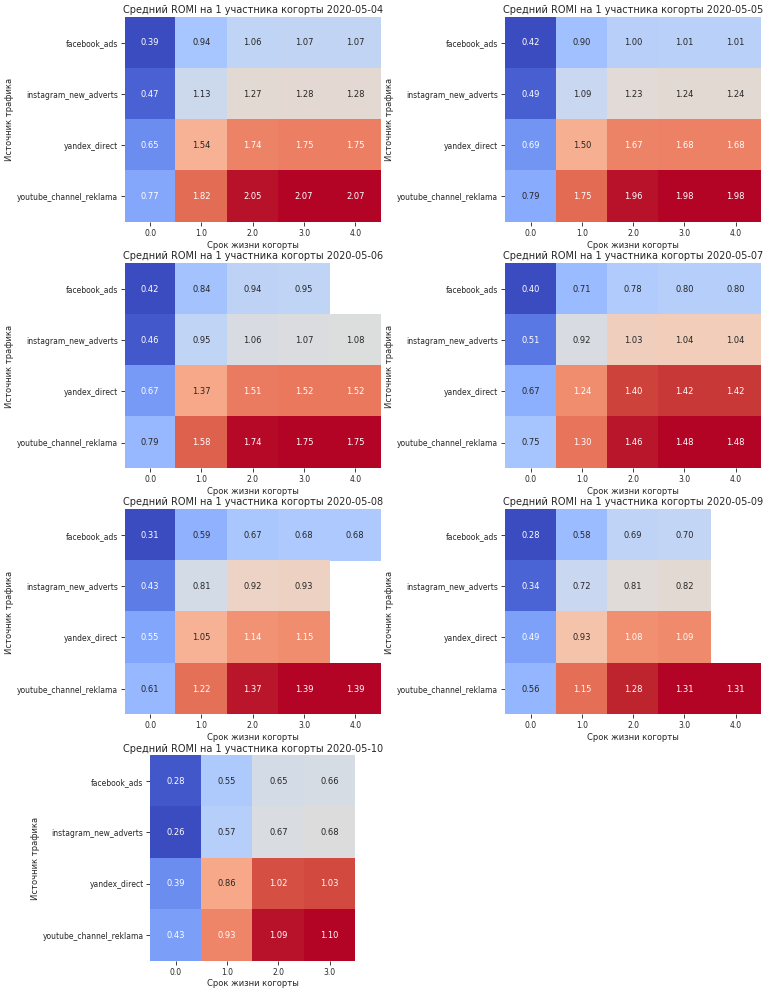

In [121]:
x = 4 
y = 2 
y_ = 0
x_ = 0

fig, axes = plt.subplots(figsize=(18, 25), dpi=50)
for row in romi['first_date'].drop_duplicates():
    ax = plt.subplot2grid((x, y), (x_, y_))
    data = romi[romi['first_date'] == row].pivot_table(
        index='source', columns='cohort_lifetime', values='romi', aggfunc='mean'
    ).cumsum(axis=1).round(2)
    sns.heatmap(data=data, ax=ax, cmap='coolwarm', annot=True, fmt='.2f', square=True, cbar=False)
    ax.set_title('Cредний ROMI на 1 участника когорты {:%Y-%m-%d}'.format(row), fontsize=14)
    ax.set_xlabel('Срок жизни когорты')
    ax.set_ylabel('Источник трафика')
    y_ += 1
    
    if y_ == y:
        x_ += 1
        y_ = 0

По всем когоротам источники можно выстроить от наименее окупаемого к самому эффективному:
* Фейсбук
* Инстаграм
* Яндекс
* Ютуб

Чем старше когорта, тем менее окупаемы становятся источники.

Посмотрим на соотношение кумулятивных ROMI на 1 участника когорты в разрезе источников трафика

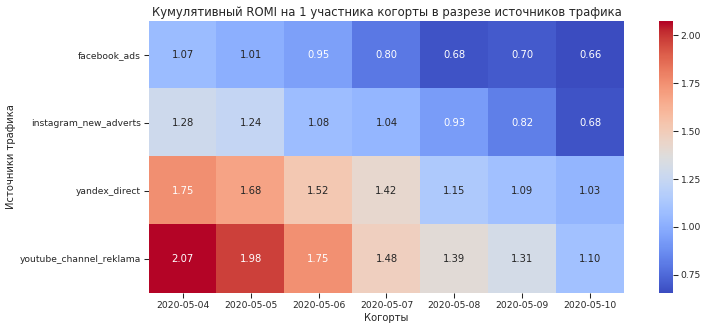

In [122]:
data = romi.pivot_table(index='first_date', columns='source', values='romi', aggfunc='sum')
data.index = data.index.strftime("%Y-%m-%d")
plt.figure(figsize=(15, 6), dpi=60)
sns.heatmap(data=data.T, cmap= 'coolwarm', annot=True, fmt = '.2f', square=True)
plt.title('Кумулятивный ROMI на 1 участника когорты в разрезе источников трафика', fontsize=14)
plt.xlabel('Когорты')
plt.ylabel('Источники трафика')
plt.show()

Наименьший ROMI по всем когортам у Фейсбука - средняя окупаемость преодолевает сумму маркетинговых инвестиций только у двух когорт, тогда как Ютуб отбивает вложенные затраты в 2 раза у первых двух когорот.

Для всех когорт самыми окупаемыми становятся Ютуб и Яндекс Директ.

<a id='source_analysis_conclusion'></a>
## Вывод по пункту 3

Завершение первого уровня требует от игрока выполнения одного из двух условий - выполнение проекта или победы над соперником. Топовые стратегии победы у игроков основаны не на завершении проекта, доля прошедших уровень через проект от всех завершивших первый уровень составляет 32%.    
Основные шаги в топовых стратегиях: assembly shop, от 1 до 5 spaceport и завершение уровня через победу над врагом.   
Топовые стратегии заставляют быть в игре разное количество времени, но чем больше построек, тем длительность в игре больше (в среднем 2 дня на 1 постройку).    

Рекомендуется проверить игровой баланс в области строительства research_center и реализации проекта первого уровня, возможно, этот путь воспринимается игроками как слишком сложный. Если игроки будут более охотно реализовывать проект, то будут возводить дополнительные постройки и дольше проводить время на первом уровне, значит, больше возможности для монетизации и окупаемости маркетинговых затрат.

Наиболее популярный источник входа в игру - это Яндекс Директ. Наибольшее число игроков по каждому из источников наблюдается на 7й день (10.05.2021). К концу первой недели количество игроков снижается на 10-15%. После первой недели игры идет резкий спад на протяжении следующих двух недель (40-50% на второй неделе и не более 10% на третьй), на последней неделе игроков меньше 1%. В целом тенденция изменения количества игроков в разных кластерах идентична, основная активность в игре наблюдается в течение 3 недель. В среднем на завершение уровня нужно 12 дней. По всем источникам наблюдается тенденция более длительного пребывания в игре в случае завершения первого уровня. Игроки, пришедшие через Яндекс, завершают уровень через проект в 30% от всех завершивших уровень, в остальных источниках 32%-34%. Вне зависимости от источника на каждого игрока приходится в среднем 10 построек на первом уровне.

Средние значения DAU/WAU:   
2884 уникальных пользователей в день    
6120 уникальных пользователей в неделю    

Средняя стоимость привлечения одного игрока: 0.56 у.е.
Стоимость показа рекламы на одну постройку в точке безубыточности составляет 0.06 у.е.

Наиболее дешевый источник привлечения - это реклама в Ютубе, а самый затратный на одного игрока - это Фейсбук, стоимость привлечения одного игрока здесь почти в 2 раза больше, чем через Ютуб (0,4 у.е. против 0,79 у.е.), при этом оба этих канала привлекли приблизительно одинаковое количество игроков за весь анализируемый период (2686 и 2726 человек соответственно).
Через Яндекс пришло максимальное число игроков (4817 юзеров) при стоимости привлечения 0,46 у.е.
Инстаграм является довольно дорогим источником (0,65 у.е. на игрока), но через него пришла четверть всех игроков.

С учетом допущения о равномерности оттока вследствие показа реклама на 15% и уровне доходности в размере 10%, была заложена стоимость рекламы в размере 0.08 у.е. за показ на экране с выбором типа постройки. Такая модель позволяет окупить инвестиции в маркетинг на десятый день со старта игры при выбранной стоимости.

В течение недели с момента запуска игры добавлялись новые пользователи, по ним были сформированы когороты, анализ времени жизни когорот проводился по неделям. У когорт, сформированных в первые два дня после запуска игры, наибольшие показатели доли уникальных игроков в течение жизни когорты.
По всем когоротам источники можно выстроить от наименее окупаемого к самому эффективному:

 * Фейсбук (окупился только у первой и второй когорот)
 * Инстаграм (окупились 4 когорты из 7, в среднем окупаемость происходит после 2х недель)
 * Яндекс (окупились все когорты, в среднем окупаемость наступает уже после первой недели)
 * Ютуб (окупились все когорты, в среднем окупаемость наступает уже после первой недели)    
 
Чем старше когорта, тем менее окупаемы становятся источники.

Вероятнее всего на окупаемость источников влияет насколько аудитория источника потенциально пересекается с аудиторией игроков, предпочитающих мобильные игры в жанре стратегий и pvp - фейсбук в этом случае проигрывает Яндексу Директ и Ютубу.

<a id='tests'></a>
## 4 Проверка статистических гипотез

<a id='tests_1'></a>
### 4.1 Различия во времени завершения уровня в зависимости от способа прохождения уровня

Посмотрим средние значения по времени завершения уровня тех, кто прошел с помощью проекта и с помощью победы над соперником

In [123]:
round(events_by_users[events_by_users['is_complete'] == 1].
      groupby('through_project')['days_to_complete'].mean(), 0)

through_project
0   12.00
1   14.00
Name: days_to_complete, dtype: float64

Посмотрим на распределение по дням количества игроков, завершающих уровень

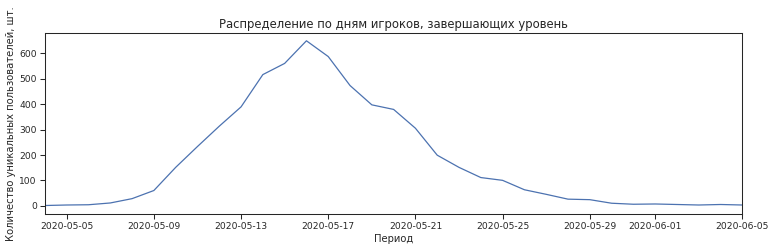

In [124]:
fig, ax = plt.subplots(figsize=(12,5), dpi=60)
events_by_users[events_by_users['is_complete'] == 1]['last_date'].value_counts().plot(figsize=(15,4))
plt.title('Распределение по дням игроков, завершающих уровень', fontsize=14)
plt.xlabel('Период')
plt.ylabel('Количество уникальных пользователей, шт.')
plt.show()

Распределение похоже на нормальное, для анализа статистичекой значимости средних значений применим t-test

Сформулируем гипотезы   
H0: Среднее время на завершение уровня через проект = Среднее время на завершение уровня через победу    
H1: Среднее время на завершение уровня через проект > Среднего времени на завершение уровня через победу

In [125]:
print("Дисперсия времени на завершение уровня через проект {:.5}"
      .format(np.var(events_by_users[(events_by_users['is_complete'] == 1)
                       & (events_by_users['through_project'] == 1)]['days_to_complete']), 2))
print("Дисперсия времени на завершение уровня через победу {:.5}"
      .format(np.var(events_by_users[(events_by_users['is_complete'] == 1)
                       & (events_by_users['through_project'] == 0)]['days_to_complete']), 2))

Дисперсия времени на завершение уровня через проект 12.402
Дисперсия времени на завершение уровня через победу 16.846


Дисперсии отличаются порядка 35%, при проведении t-теста применяем параметр equal_var = False.    
Поскольку в гипотезе проверяется, что одно значение больше другого, применим односторонний тест, для этого возьмем половину значения p и сравним с уровнем значимости alpha.    

In [126]:
len(events_by_users[(events_by_users['is_complete'] == 1)
                       & (events_by_users['through_project'] == 1)])

1866

In [127]:
len(events_by_users[(events_by_users['is_complete'] == 1)
                       & (events_by_users['through_project'] == 0)])

3951

При малом объеме выборки более вероятно получить случайный результат, а при увеличении объема выборки случайные отклонения компенсируют друг друга, и получить значимое различие в выборках при их однородности менее вероятно. Учитывая, что объем выборки по игрокам, реализовавшим проект, составляет 1866, а по игрокам, победившим соперника - 3951, выберем для проведения статистического анализа стандартный уровень значимости. Определим уровень значимости в размере 5%.

In [128]:
results = st.ttest_ind(events_by_users[(events_by_users['is_complete'] == 1)
                       & (events_by_users['through_project'] == 1)]['days_to_complete'],
                       
                       events_by_users[(events_by_users['is_complete'] == 1)
                       & (events_by_users['through_project'] == 0)]['days_to_complete'], equal_var = False)

print('p-значение: ', results.pvalue / 2)

p-значение:  3.285233377821818e-105


In [129]:
alpha = .05
if (results.pvalue / 2 < alpha):
    print("Отвергаем нулевую гипотезу, среднее время на завершение уровня через проект больше")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Отвергаем нулевую гипотезу, среднее время на завершение уровня через проект больше


Полученное значение p-value говорит о том, что с очень малой вероятностью, стремящейся к 0, найденное различие в среднем времени прохождения первого уровня разными способами можно получить случайно, таким образом, выбранный критерий значимости не был превышен, можем отвергнуть нулевую гипотезу и сделать вывод о статистической значимости большего времени на прохождение уровня через проект по данным выборки.

<a id='tests_2'></a>
### 4.2 Различия в способе завершения уровня в зависимости от источника перехода в игру

Проверим гипотезу: пришедшие через Яндекс реже завершают уровень через проект

In [130]:
events_by_users[events_by_users['is_complete'] == 1].groupby('source')['through_project'].mean()

source
facebook_ads              0.34
instagram_new_adverts     0.32
yandex_direct             0.30
youtube_channel_reklama   0.33
Name: through_project, dtype: float64

В данной гипотезе снова проверяются средние значения, воспользуемся t-тестом

In [131]:
def t_testing(arg, values, alpha):
    '''Calculate the t-statistic'''
    
    print('H0: средняя доля завершающих через проект по источникам {} и {} не различается'.
          format(values[0], values[1]))
    print('H1: средняя доля завершающих через проект в источнике {} больше, чем у {}'.
          format(values[0], values[1]))
    results = st.ttest_1samp(events_by_users[(events_by_users['is_complete'] == 1)
                       & (events_by_users['through_project'] == 1) 
                       & (events_by_users[arg] == values[0])]['days_to_complete'],
                             
                       events_by_users[(events_by_users['is_complete'] == 1)
                       & (events_by_users['through_project'] == 0)
                    & (events_by_users[arg] == values[1])]['days_to_complete'].mean())
    print('')
    print('p-значение: ', results.pvalue)
    
    if (results.pvalue < alpha) and (events_by_users[(events_by_users['is_complete'] == 1)
                       & (events_by_users['through_project'] == 1) 
                       & (events_by_users[arg] == values[0])]['days_to_complete'].mean() 
                                     > events_by_users[(events_by_users['is_complete'] == 1)
                       & (events_by_users['through_project'] == 0)
                    & (events_by_users[arg] == values[1])]['days_to_complete'].mean()):
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")

Поскольку будут сраниваться попарно между собой 3 группы, применим поправку Бонферрони на множественные сравнения, тогда уровень alpha будет 0.05 / 3

In [132]:
t_testing('source', ['facebook_ads', 'yandex_direct'], .05 / 3)

H0: средняя доля завершающих через проект по источникам facebook_ads и yandex_direct не различается
H1: средняя доля завершающих через проект в источнике facebook_ads больше, чем у yandex_direct

p-значение:  6.314144284683304e-31
Отвергаем нулевую гипотезу


In [133]:
t_testing('source', ['instagram_new_adverts', 'yandex_direct'], .05 / 3)

H0: средняя доля завершающих через проект по источникам instagram_new_adverts и yandex_direct не различается
H1: средняя доля завершающих через проект в источнике instagram_new_adverts больше, чем у yandex_direct

p-значение:  4.95204431041357e-43
Отвергаем нулевую гипотезу


In [134]:
t_testing('source', ['youtube_channel_reklama', 'yandex_direct'], .05 / 3)

H0: средняя доля завершающих через проект по источникам youtube_channel_reklama и yandex_direct не различается
H1: средняя доля завершающих через проект в источнике youtube_channel_reklama больше, чем у yandex_direct

p-значение:  1.079827138920653e-35
Отвергаем нулевую гипотезу


Таким образом, гипотеза о том, что в разных источниках в среднем одинаковая доля пользователей завершает уровень через проект, была отвергнута, данные выборки не противоречат гипотезе о том, что пришедшие через Яндекс реже завершают уровень через проект, чем из любого другого источника.

<a id='tests_conclusion'></a>
## Вывод по пункту 4

Для выбранного критерия значимости на уровне 5% проведенный тест позволил отбросить нулевую гипотезу и сделать вывод о том, что на завершение уровня через проект игроку в среднем необходимо больше времени. Таким образом, реализация стратегии победы через проект будет являться более предпочтительной для нас, чтобы повысить окупаемость маркетинговых затрат через увеличение количества показов рекламы на экране выбора постройки.

Также проведенные тесты с уровнем значимости в 5%, скорректированном на поправку для множественных сравнений, показали, что данные выборки не противоречат гипотезе о том, что пришедшие через Яндекс реже завершают уровень через проект, чем из любого другого источника. То есть игроки, перешедшие через Яндекс Директ чаще побеждают других игроков и тем самым завершают уровень.

<a id='total_conclusion'></a>
## Общий вывод

**Целью** ставился анализ расходов на маркетинг, чтобы сделать вывод об эффективности источников перехода в игру.

Для этого были проанализированы 3 датасета, содержащие информацию о событиях на первом уровне игры (с 04.05.2020 до 05.06.2020), источниках перехода и маркетинговых затратах.

Количество событий за анализируемый период: 135639     
Количество уникальных игроков: 13576 человека (старт в игре в период с 4 по 10 мая включительно)    
Суммарные затраты на маркетинг: 7603.58 у.е.   
Суммарная стоимость показов рекламы (стоимость 0.08 у.е., показы на экране выбора постройки): 10236.48 у.е.    
Средняя стоимость привлечения одного игрока: 0.56 у.е.   
Стоимость показа рекламы на одну постройку в точке безубыточности: 0.06 у.е.   
2884 уникальных пользователей в день    
6120 уникальных пользователей в неделю

**Выявленные особенности:**    
Пик событий происходит через неделю после старта. Наиболее популярное событие - постройка (94% всех событий). 
Прошли первый уровень 43% уникальных игроков, среди них с помощью проекта только 32%. **Наиболее популярная стратегия победы - победа над врагом** (68% завершивших уровень). 

В среднем игрокам нужно 12 дней, чтобы закончить первый уровень. В среднем те, кто завершают первый уровень, проводят в игре на 2 дня больше.

Самое раннее, когда игрокам удается завершить игру - на второй день с момента запуска, в первые двенадцать дней каждый день уходят большее количество игроков, не завершивших уровень. Максимальный отток происходит на 10-11 день.

**Наиболее дешевый источник привлечения - это реклама в Ютубе, а самый затратный на одного игрока - это Фейсбук**, стоимость привлечения одного игрока здесь почти в 2 раза больше, чем через Ютуб (0,4 у.е. против 0,79 у.е.), при этом оба этих канала привлекли приблизительно одинаковое количество игроков за весь анализируемый период (2686 и 2726 человек соответственно). Через Яндекс пришло максимальное число игроков (4817 юзеров) при стоимости привлечения 0,46 у.е. Инстаграм является довольно дорогим источником (0,65 у.е. на игрока), но через него пришла четверть всех игроков.

Чем старше когорта, тем менее окупаемы становятся источники.

**Источники в порядке окупаемости**, начиная с максимального: 
* Ютуб (окупились все когорты, в среднем окупаемость наступает уже после первой недели)
* Яндекс (окупились все когорты, в среднем окупаемость наступает уже после первой недели)
* Инстаграм (окупились 4 когроты из 7, в среднем окупаемость происходит после 2х недель)
* Фейсбук (окупился только у первой и второй когорот)



**Рекомендации:**
 * проверить игровой баланс в области строительства research_center и реализации проекта первого уровня
 * перераспределить маркетинговый бюджет в сторону более окупаемых источников (от Фейсбука к Яндексу и Ютубу), больше обращать внимание на аудиторию, в которой происходит реклама
 * основные траты маркетингового бюджета осуществлять на старте (так как наиболее окупаемые первые две когорты)
 * стимулировать игроков к прохождению игры через проект, особенно пришедших через Яндекс директ (время в игре при реализации проекта выше, чем при прохождении уровня победой над врагом, что подтверждено статистическим тестом с 5%-ным уровнем значимости)
 

<a id='present'></a>
[Презентация по проекту](https://drive.google.com/file/d/14xZGBIQCFXkcvYvkVDMVr_LmOjc8758A/view?usp=sharing)

<a id='dash'></a>
[Дашборд](https://public.tableau.com/app/profile/eugen7144/viz/Building_in_game/Dashboard1)